# Data Preparation

In [ ]:
# 1.1 Download dataset via kagglehub and locate Cropped100x

!pip -q install kagglehub

import os
from pathlib import Path
import kagglehub

DATASET_ID = "sahini/surface-roughness-classification"
TARGET_DIRNAME = "Cropped100x"

root = Path(kagglehub.dataset_download(DATASET_ID))
print("Downloaded dataset root:", root)

# Find Cropped100x anywhere inside the downloaded directory
candidates = [p for p in root.rglob(TARGET_DIRNAME) if p.is_dir()]
if not candidates:
    raise FileNotFoundError(f"Could not find folder '{TARGET_DIRNAME}' under: {root}")

cropped_dir = candidates[0]
print("Cropped100x path:", cropped_dir)

# Show immediate subfolders (should be 16 class folders)
class_dirs = sorted([p.name for p in cropped_dir.iterdir() if p.is_dir()])
print("Found class folders:", class_dirs)
print("Num classes:", len(class_dirs))

100%|██████████| 263M/263M [00:09<00:00, 28.3MB/s]

Extracting files...


Downloaded dataset root: /root/.cache/kagglehub/datasets/sahini/surface-roughness-classification/versions/1
Cropped100x path: /root/.cache/kagglehub/datasets/sahini/surface-roughness-classification/versions/1/Cropped100x
Found class folders: ['00', '03', '06', '09', '12', '15', '18', '21', '24', '27', '30', '33', '36', '39', '42', '45']
Num classes: 16


In [ ]:
# 1.2 Verify dataset structure and basic statistics

from collections import OrderedDict

image_exts = {".jpg", ".jpeg", ".png"}

class_stats = OrderedDict()

for class_dir in sorted(cropped_dir.iterdir()):
    if not class_dir.is_dir():
        continue

    images = [
        p for p in class_dir.iterdir()
        if p.suffix.lower() in image_exts
    ]
    class_stats[class_dir.name] = len(images)

# Print stats
total_images = sum(class_stats.values())

print(f"Total images: {total_images}\n")
print("Images per class:")
for cls, cnt in class_stats.items():
    print(f"  class {cls}: {cnt}")

# Quick sanity checks
assert len(class_stats) == 16, "Expected exactly 16 classes"
assert all(v > 0 for v in class_stats.values()), "Some class has zero images"


Total images: 3840

Images per class:
  class 00: 240
  class 03: 240
  class 06: 240
  class 09: 240
  class 12: 240
  class 15: 240
  class 18: 240
  class 21: 240
  class 24: 240
  class 27: 240
  class 30: 240
  class 33: 240
  class 36: 240
  class 39: 240
  class 42: 240
  class 45: 240


In [ ]:
# 1.3 Build DataFrame with image paths and labels

import pandas as pd

rows = []

for class_dir in sorted(cropped_dir.iterdir()):
    if not class_dir.is_dir():
        continue

    class_name = class_dir.name
    for img_path in class_dir.iterdir():
        if img_path.suffix.lower() in image_exts:
            rows.append({
                "path": str(img_path),
                "class_name": class_name
            })

df = pd.DataFrame(rows)

# Create class mappings (sorted for reproducibility)
class_names = sorted(df["class_name"].unique())
class_to_idx = {cls: i for i, cls in enumerate(class_names)}
idx_to_class = {i: cls for cls, i in class_to_idx.items()}

df["label"] = df["class_name"].map(class_to_idx)

# Sanity checks
print("DataFrame shape:", df.shape)
print("\nClass mapping:")
for k, v in class_to_idx.items():
    print(f"  {k} -> {v}")

print("\nHead:")
df.head()


DataFrame shape: (3840, 3)

Class mapping:
  00 -> 0
  03 -> 1
  06 -> 2
  09 -> 3
  12 -> 4
  15 -> 5
  18 -> 6
  21 -> 7
  24 -> 8
  27 -> 9
  30 -> 10
  33 -> 11
  36 -> 12
  39 -> 13
  42 -> 14
  45 -> 15

Head:


,path,class_name,label
0,/root/.cache/kagglehub/datasets/sahini/surface...,00,0
1,/root/.cache/kagglehub/datasets/sahini/surface...,00,0
2,/root/.cache/kagglehub/datasets/sahini/surface...,00,0
3,/root/.cache/kagglehub/datasets/sahini/surface...,00,0
4,/root/.cache/kagglehub/datasets/sahini/surface...,00,0


In [ ]:
# 1.4 Stratified train/val/test split (70/15/15) with reproducibility

from sklearn.model_selection import train_test_split
import numpy as np

SEED = 42
np.random.seed(SEED)

# 1) test split: 15% of total
df_trainval, df_test = train_test_split(
    df,
    test_size=0.15,
    random_state=SEED,
    stratify=df["label"]
)

# 2) val split: 15% of total => 0.15 / 0.85 of trainval
val_ratio_within_trainval = 0.15 / 0.85

df_train, df_val = train_test_split(
    df_trainval,
    test_size=val_ratio_within_trainval,
    random_state=SEED,
    stratify=df_trainval["label"]
)

# Reset indices for cleanliness
df_train = df_train.reset_index(drop=True)
df_val   = df_val.reset_index(drop=True)
df_test  = df_test.reset_index(drop=True)

print("Split sizes:")
print("  train:", len(df_train))
print("  val:  ", len(df_val))
print("  test: ", len(df_test))
print("  total:", len(df_train) + len(df_val) + len(df_test))

def split_distribution(name, dframe):
    counts = dframe["label"].value_counts().sort_index()
    return pd.DataFrame({
        "split": name,
        "label": counts.index,
        "count": counts.values
    })

dist = pd.concat([
    split_distribution("train", df_train),
    split_distribution("val", df_val),
    split_distribution("test", df_test),
], ignore_index=True)

print("\nPer-class counts (should be equal within each split):")
display(dist.pivot(index="label", columns="split", values="count"))

# Optional: sanity-check exact expected counts per class (because dataset is perfectly balanced)
# total per class = 240
# expected: train=168, val=36, test=36
expected = {"train": 168, "val": 36, "test": 36}
pivot = dist.pivot(index="label", columns="split", values="count")
assert all((pivot["train"] == expected["train"]) & (pivot["val"] == expected["val"]) & (pivot["test"] == expected["test"])), \
    "Unexpected per-class split counts; check stratification/sizes."

print("\nAll good: stratified split matches expected counts per class.")


Split sizes:
  train: 2688
  val:   576
  test:  576
  total: 3840

Per-class counts (should be equal within each split):


split,test,train,val
label,,,
0,36,168,36
1,36,168,36
2,36,168,36
3,36,168,36
4,36,168,36
5,36,168,36
6,36,168,36
7,36,168,36
8,36,168,36



All good: stratified split matches expected counts per class.


In [ ]:
# 2.1 Dataset + basic preprocessing (grayscale, resize, [0,1]) -> (1,H,W)

from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import numpy as np

IMAGE_SIZE = 64  # fixed for all models

class SurfaceRoughnessDataset(Dataset):
    def __init__(self, df, image_size=64):
        self.df = df.reset_index(drop=True)
        self.image_size = image_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["path"]
        y = int(row["label"])

        # Read image
        img = Image.open(path).convert("L")  # grayscale

        # Resize
        img = img.resize((self.image_size, self.image_size), resample=Image.BILINEAR)

        # To numpy [0,1]
        arr = np.asarray(img, dtype=np.float32) / 255.0  # (H,W)

        # To torch tensor (1,H,W)
        x = torch.from_numpy(arr).unsqueeze(0)  # (1,H,W), float32
        y = torch.tensor(y, dtype=torch.long)   # scalar long

        return x, y

# Create datasets
train_ds = SurfaceRoughnessDataset(df_train, image_size=IMAGE_SIZE)
val_ds   = SurfaceRoughnessDataset(df_val,   image_size=IMAGE_SIZE)
test_ds  = SurfaceRoughnessDataset(df_test,  image_size=IMAGE_SIZE)

# Quick loader sanity check
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

xb, yb = next(iter(train_loader))
print("x batch:", xb.shape, xb.dtype, "min/max:", float(xb.min()), float(xb.max()))
print("y batch:", yb.shape, yb.dtype, "min/max:", int(yb.min()), int(yb.max()))


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


x batch: torch.Size([32, 1, 64, 64]) torch.float32 min/max: 0.01568627543747425 1.0
y batch: torch.Size([32]) torch.int64 min/max: 0 15


In [ ]:
# 2.2 Reproducibility: seeds and deterministic behavior

import random
import torch
import numpy as np

SEED = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # For full determinism (may slow down a bit)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

print("Seeds set to:", SEED)


Seeds set to: 42


In [ ]:
# 3.x / 7.x Metrics core (from scratch, no sklearn)

import torch

@torch.no_grad()
def confusion_matrix_torch(y_true: torch.Tensor, y_pred: torch.Tensor, num_classes: int) -> torch.Tensor:
    """
    y_true: (N,) long
    y_pred: (N,) long
    returns: (C,C) where rows=true, cols=pred
    """
    y_true = y_true.view(-1).long()
    y_pred = y_pred.view(-1).long()
    cm = torch.zeros((num_classes, num_classes), dtype=torch.int64)
    # bincount trick: index = true*C + pred
    idx = y_true * num_classes + y_pred
    bc = torch.bincount(idx, minlength=num_classes*num_classes)
    cm += bc.reshape(num_classes, num_classes)
    return cm

@torch.no_grad()
def accuracy_top1(y_true, y_pred):
    return (y_true == y_pred).float().mean().item()

@torch.no_grad()
def accuracy_topk(y_true: torch.Tensor, logits: torch.Tensor, k: int = 2) -> float:
    """
    logits: (N,C)
    """
    topk = torch.topk(logits, k=k, dim=1).indices  # (N,k)
    y_true = y_true.view(-1, 1)
    correct = (topk == y_true).any(dim=1)
    return correct.float().mean().item()

@torch.no_grad()
def per_class_prf_from_cm(cm: torch.Tensor, eps: float = 1e-12):
    """
    cm: (C,C) int64; rows=true, cols=pred
    returns dict with per-class precision/recall/f1 + macro-f1 + balanced-acc
    """
    cm = cm.to(torch.float32)
    tp = torch.diag(cm)
    fp = cm.sum(dim=0) - tp
    fn = cm.sum(dim=1) - tp

    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)

    macro_f1 = f1.mean().item()
    balanced_acc = recall.mean().item()  # mean recall across classes

    return {
        "precision_per_class": precision,
        "recall_per_class": recall,
        "f1_per_class": f1,
        "macro_f1": macro_f1,
        "balanced_acc": balanced_acc
    }

# Quick self-test on a tiny toy example
y_true = torch.tensor([0,0,1,1,2,2])
y_pred = torch.tensor([0,1,1,1,2,0])
cm = confusion_matrix_torch(y_true, y_pred, num_classes=3)
stats = per_class_prf_from_cm(cm)

print("Toy CM:\n", cm)
print("Toy acc:", accuracy_top1(y_true, y_pred))
print("Toy macro_f1:", stats["macro_f1"])
print("Toy balanced_acc:", stats["balanced_acc"])
print("Toy per-class F1:", stats["f1_per_class"].tolist())


Toy CM:
 tensor([[1, 1, 0],
        [0, 2, 0],
        [1, 0, 1]])
Toy acc: 0.6666666865348816
Toy macro_f1: 0.6555555462837219
Toy balanced_acc: 0.6666666865348816
Toy per-class F1: [0.5, 0.800000011920929, 0.6666666865348816]


In [ ]:
# 9.1 evaluate_model(...) + stable CE loss from logits (usable for all models)

import time
import torch

def logsumexp(x: torch.Tensor, dim: int = -1, keepdim: bool = False):
    m, _ = torch.max(x, dim=dim, keepdim=True)
    y = m + torch.log(torch.sum(torch.exp(x - m), dim=dim, keepdim=True))
    return y if keepdim else y.squeeze(dim)

def cross_entropy_from_logits(logits: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    logits: (B,C)
    y: (B,) long
    returns: scalar mean CE
    """
    # log softmax: logits - logsumexp
    lse = logsumexp(logits, dim=1, keepdim=True)   # (B,1)
    log_probs = logits - lse                       # (B,C)
    nll = -log_probs[torch.arange(logits.size(0)), y]
    return nll.mean()

@torch.no_grad()
def evaluate_model(
    loader,
    num_classes: int,
    device: torch.device,
    model=None,
    forward_fn=None,       # for scratch models: forward_fn(x)->logits
    loss_fn=None,          # optional custom loss; default CE from logits
    topk: int = 2
):
    """
    Returns dict with: loss, acc, top2_acc, macro_f1, balanced_acc, cm, per-class metrics
    """
    assert (model is not None) ^ (forward_fn is not None), "Provide exactly one: model or forward_fn"
    if loss_fn is None:
        loss_fn = cross_entropy_from_logits

    total_loss = 0.0
    total_n = 0

    all_true = []
    all_pred = []
    all_logits = []

    if model is not None:
        model.eval()

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)

        logits = model(xb) if model is not None else forward_fn(xb)  # (B,C)
        loss = loss_fn(logits, yb)

        total_loss += float(loss.item()) * xb.size(0)
        total_n += xb.size(0)

        preds = torch.argmax(logits, dim=1)

        all_true.append(yb.detach().cpu())
        all_pred.append(preds.detach().cpu())
        all_logits.append(logits.detach().cpu())

    y_true = torch.cat(all_true, dim=0)
    y_pred = torch.cat(all_pred, dim=0)
    logits_all = torch.cat(all_logits, dim=0)

    cm = confusion_matrix_torch(y_true, y_pred, num_classes=num_classes)
    prf = per_class_prf_from_cm(cm)

    metrics = {
        "loss": total_loss / max(total_n, 1),
        "acc": accuracy_top1(y_true, y_pred),
        "top2_acc": accuracy_topk(y_true, logits_all, k=topk) if topk is not None else None,
        "macro_f1": prf["macro_f1"],
        "balanced_acc": prf["balanced_acc"],
        "confusion_matrix": cm,
        "precision_per_class": prf["precision_per_class"],
        "recall_per_class": prf["recall_per_class"],
        "f1_per_class": prf["f1_per_class"],
    }
    return metrics

# Sanity-check evaluate_model using a dummy forward_fn producing random logits
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 16

val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2)

def dummy_forward(x):
    B = x.size(0)
    return torch.randn(B, NUM_CLASSES, device=x.device)

m = evaluate_model(val_loader, num_classes=NUM_CLASSES, device=device, forward_fn=dummy_forward)
print({k: m[k] for k in ["loss", "acc", "top2_acc", "macro_f1", "balanced_acc"]})
print("CM shape:", m["confusion_matrix"].shape)


{'loss': 3.245748069551256, 'acc': 0.0677083358168602, 'top2_acc': 0.1267361044883728, 'macro_f1': 0.06640196591615677, 'balanced_acc': 0.0677083358168602}
CM shape: torch.Size([16, 16])


# Softmax Regression

In [ ]:
# 4.3 Full Softmax Regression training with grid search + best checkpoint

import os, time
import pandas as pd
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 16
D = IMAGE_SIZE * IMAGE_SIZE

os.makedirs("checkpoints", exist_ok=True)

# Loaders (fixed across runs)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, num_workers=2)

# --- model + math (same as before) ---
def stable_softmax(logits: torch.Tensor) -> torch.Tensor:
    m, _ = torch.max(logits, dim=1, keepdim=True)
    exps = torch.exp(logits - m)
    return exps / torch.sum(exps, dim=1, keepdim=True)

def cross_entropy_from_probs(probs: torch.Tensor, y: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
    p = probs[torch.arange(probs.size(0), device=probs.device), y]
    return (-torch.log(p + eps)).mean()

def one_hot(y: torch.Tensor, num_classes: int) -> torch.Tensor:
    oh = torch.zeros((y.size(0), num_classes), device=y.device, dtype=torch.float32)
    oh[torch.arange(y.size(0), device=y.device), y] = 1.0
    return oh

class SoftmaxRegressionScratch:
    def __init__(self, input_dim: int, num_classes: int, seed: int, device: torch.device):
        g = torch.Generator(device="cpu")
        g.manual_seed(seed)
        self.W = (torch.randn(input_dim, num_classes, generator=g) * 0.01).to(device)
        self.b = torch.zeros(num_classes, device=device)

    def forward_logits(self, x: torch.Tensor) -> torch.Tensor:
        X = x.view(x.size(0), -1)
        return X @ self.W + self.b

    def train_step(self, x: torch.Tensor, y: torch.Tensor, lr: float, weight_decay: float):
        B = x.size(0)
        X = x.view(B, -1)
        logits = X @ self.W + self.b
        probs = stable_softmax(logits)
        loss = cross_entropy_from_probs(probs, y)

        dlogits = (probs - one_hot(y, NUM_CLASSES)) / B
        dW = X.t() @ dlogits
        db = dlogits.sum(dim=0)

        if weight_decay > 0:
            dW = dW + weight_decay * self.W

        self.W = self.W - lr * dW
        self.b = self.b - lr * db

        return float(loss.item())

def train_one_run(epochs, lr, weight_decay, seed):
    model = SoftmaxRegressionScratch(D, NUM_CLASSES, seed=seed, device=device)

    history = {
        "train_loss": [],
        "val_loss": [],
        "val_acc": [],
        "val_macro_f1": [],
        "val_balanced_acc": [],
        "val_top2_acc": [],
        "sec_per_epoch": [],
    }

    t_total0 = time.time()

    for ep in range(1, epochs + 1):
        t0 = time.time()
        loss_sum, n_seen = 0.0, 0

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            l = model.train_step(xb, yb, lr=lr, weight_decay=weight_decay)
            bs = xb.size(0)
            loss_sum += l * bs
            n_seen += bs

        train_loss = loss_sum / n_seen

        forward_fn = lambda x: model.forward_logits(x)
        val_metrics = evaluate_model(val_loader, num_classes=NUM_CLASSES, device=device, forward_fn=forward_fn)

        dt = time.time() - t0

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_metrics["loss"])
        history["val_acc"].append(val_metrics["acc"])
        history["val_macro_f1"].append(val_metrics["macro_f1"])
        history["val_balanced_acc"].append(val_metrics["balanced_acc"])
        history["val_top2_acc"].append(val_metrics["top2_acc"])
        history["sec_per_epoch"].append(dt)

    total_time = time.time() - t_total0
    best_val_macro_f1 = max(history["val_macro_f1"])

    return model, history, total_time, best_val_macro_f1

# --- grid search ---
grid_epochs = [5, 10, 20, 35]
grid_lr = [1e-2, 3e-3, 1e-3]
grid_wd = [0.0, 1e-4, 1e-3]

runs = []
best = {"score": -1.0, "cfg": None, "model": None, "history": None, "time": None, "val_metrics": None}

run_id = 0
for epochs in grid_epochs:
    for lr in grid_lr:
        for wd in grid_wd:
            run_id += 1
            print(f"\nRun {run_id}/{len(grid_epochs)*len(grid_lr)*len(grid_wd)} | epochs={epochs} lr={lr} wd={wd}")
            model, history, total_time, best_val_macro_f1 = train_one_run(epochs, lr, wd, seed=SEED)

            # final val metrics at last epoch (for reporting)
            forward_fn = lambda x: model.forward_logits(x)
            val_metrics_last = evaluate_model(val_loader, num_classes=NUM_CLASSES, device=device, forward_fn=forward_fn)

            runs.append({
                "run_id": run_id,
                "epochs": epochs,
                "lr": lr,
                "weight_decay": wd,
                "best_val_macro_f1": best_val_macro_f1,
                "val_macro_f1_last": val_metrics_last["macro_f1"],
                "val_acc_last": val_metrics_last["acc"],
                "val_balanced_acc_last": val_metrics_last["balanced_acc"],
                "val_loss_last": val_metrics_last["loss"],
                "sec_total": total_time,
                "sec_per_epoch_avg": sum(history["sec_per_epoch"]) / len(history["sec_per_epoch"]),
            })

            if best_val_macro_f1 > best["score"]:
                best.update({
                    "score": best_val_macro_f1,
                    "cfg": {"epochs": epochs, "lr": lr, "weight_decay": wd, "seed": SEED, "image_size": IMAGE_SIZE},
                    "model": model,
                    "history": history,
                })

# Results table
results_df = pd.DataFrame(runs).sort_values(by="best_val_macro_f1", ascending=False).reset_index(drop=True)
display(results_df.head(10))
results_df.to_csv("results_softmax.csv", index=False)
print("\nSaved grid results -> results_softmax.csv")

# --- evaluate best on val and test ---
best_model = best["model"]
best_forward = lambda x: best_model.forward_logits(x)

best_val = evaluate_model(val_loader, num_classes=NUM_CLASSES, device=device, forward_fn=best_forward)
best_test = evaluate_model(test_loader, num_classes=NUM_CLASSES, device=device, forward_fn=best_forward)

print("\nBEST CONFIG:", best["cfg"])
print("Best val metrics:", {k: best_val[k] for k in ["loss","acc","macro_f1","balanced_acc","top2_acc"]})
print("Best test metrics:", {k: best_test[k] for k in ["loss","acc","macro_f1","balanced_acc","top2_acc"]})

# --- save checkpoint ---
ckpt = {
    "W": best_model.W.detach().cpu(),
    "b": best_model.b.detach().cpu(),
    "config": best["cfg"],
    "class_to_idx": class_to_idx,
    "idx_to_class": idx_to_class,
    "history": best["history"],
    "val_confusion_matrix": best_val["confusion_matrix"],
    "test_confusion_matrix": best_test["confusion_matrix"],
    "val_metrics": {k: best_val[k] for k in ["loss","acc","macro_f1","balanced_acc","top2_acc"]},
    "test_metrics": {k: best_test[k] for k in ["loss","acc","macro_f1","balanced_acc","top2_acc"]},
}
torch.save(ckpt, "checkpoints/softmax_best.pt")
print("\nSaved checkpoint -> checkpoints/softmax_best.pt")



Run 1/36 | epochs=5 lr=0.01 wd=0.0

Run 2/36 | epochs=5 lr=0.01 wd=0.0001

Run 3/36 | epochs=5 lr=0.01 wd=0.001

Run 4/36 | epochs=5 lr=0.003 wd=0.0

Run 5/36 | epochs=5 lr=0.003 wd=0.0001

Run 6/36 | epochs=5 lr=0.003 wd=0.001

Run 7/36 | epochs=5 lr=0.001 wd=0.0

Run 8/36 | epochs=5 lr=0.001 wd=0.0001

Run 9/36 | epochs=5 lr=0.001 wd=0.001

Run 10/36 | epochs=10 lr=0.01 wd=0.0

Run 11/36 | epochs=10 lr=0.01 wd=0.0001

Run 12/36 | epochs=10 lr=0.01 wd=0.001

Run 13/36 | epochs=10 lr=0.003 wd=0.0

Run 14/36 | epochs=10 lr=0.003 wd=0.0001

Run 15/36 | epochs=10 lr=0.003 wd=0.001

Run 16/36 | epochs=10 lr=0.001 wd=0.0

Run 17/36 | epochs=10 lr=0.001 wd=0.0001

Run 18/36 | epochs=10 lr=0.001 wd=0.001

Run 19/36 | epochs=20 lr=0.01 wd=0.0

Run 20/36 | epochs=20 lr=0.01 wd=0.0001

Run 21/36 | epochs=20 lr=0.01 wd=0.001

Run 22/36 | epochs=20 lr=0.003 wd=0.0

Run 23/36 | epochs=20 lr=0.003 wd=0.0001

Run 24/36 | epochs=20 lr=0.003 wd=0.001

Run 25/36 | epochs=20 lr=0.001 wd=0.0

Run 26/36 |

,run_id,epochs,lr,weight_decay,best_val_macro_f1,val_macro_f1_last,val_acc_last,val_balanced_acc_last,val_loss_last,sec_total,sec_per_epoch_avg
0,28,35,0.010,0.0000,0.119665,0.069416,0.109375,0.109375,2.803434,71.986793,2.056756
1,29,35,0.010,0.0001,0.115222,0.094202,0.126736,0.126736,2.798516,72.767224,2.079051
2,30,35,0.010,0.0010,0.115009,0.093404,0.125000,0.125000,2.802269,72.487617,2.071064
3,19,20,0.010,0.0000,0.103596,0.059234,0.102431,0.102431,2.785883,40.834032,2.041691
4,21,20,0.010,0.0010,0.101015,0.056918,0.097222,0.097222,2.775569,41.525850,2.076280
5,20,20,0.010,0.0001,0.098092,0.069702,0.104167,0.104167,2.776751,41.574903,2.078734
6,31,35,0.003,0.0000,0.084425,0.080889,0.111111,0.111111,2.751520,72.424178,2.069250
7,10,10,0.010,0.0000,0.081547,0.046598,0.088542,0.088542,2.761206,21.031120,2.103102
8,33,35,0.003,0.0010,0.072661,0.072661,0.105903,0.105903,2.753196,72.742836,2.078357
9,32,35,0.003,0.0001,0.072483,0.063406,0.098958,0.098958,2.752240,72.010273,2.057426



Saved grid results -> results_softmax.csv

BEST CONFIG: {'epochs': 35, 'lr': 0.01, 'weight_decay': 0.0, 'seed': 42, 'image_size': 64}
Best val metrics: {'loss': 2.803434213002523, 'acc': 0.109375, 'macro_f1': 0.06941565871238708, 'balanced_acc': 0.1093750149011612, 'top2_acc': 0.1944444477558136}
Best test metrics: {'loss': 2.825076527065701, 'acc': 0.1006944477558136, 'macro_f1': 0.058142513036727905, 'balanced_acc': 0.1006944477558136, 'top2_acc': 0.203125}

Saved checkpoint -> checkpoints/softmax_best.pt


In [ ]:
# 8.x Performance metrics for baseline + 9.2 benchmark_inference

import time
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Params & size ---
num_params = best_model.W.numel() + best_model.b.numel()
model_size_mb = num_params * 4 / (1024**2)  # float32 ~ 4 bytes

print("Baseline (Softmax Regression) params:", num_params)
print("Baseline model size (MB):", model_size_mb)

# --- Inference benchmark ---
@torch.no_grad()
def benchmark_inference_forward_fn(forward_fn, loader, device, warmup_batches=10, timed_batches=50):
    """
    Measures latency (ms/image) and throughput (img/s) over timed_batches.
    Uses batch timing; reports per-image estimates.
    """
    # Optional GPU memory tracking
    use_cuda = (device.type == "cuda")
    if use_cuda:
        torch.cuda.reset_peak_memory_stats()

    it = iter(loader)

    # Warmup
    for _ in range(warmup_batches):
        try:
            xb, _ = next(it)
        except StopIteration:
            it = iter(loader)
            xb, _ = next(it)
        xb = xb.to(device)
        _ = forward_fn(xb)
        if use_cuda:
            torch.cuda.synchronize()

    # Timed
    n_images = 0
    t0 = time.perf_counter()

    for _ in range(timed_batches):
        try:
            xb, _ = next(it)
        except StopIteration:
            it = iter(loader)
            xb, _ = next(it)
        xb = xb.to(device)

        _ = forward_fn(xb)

        if use_cuda:
            torch.cuda.synchronize()

        n_images += xb.size(0)

    t1 = time.perf_counter()
    total_s = t1 - t0
    throughput = n_images / total_s
    latency_ms = (total_s / n_images) * 1000.0

    peak_mem_mb = None
    if use_cuda:
        peak_mem_mb = torch.cuda.max_memory_allocated() / (1024**2)

    return {
        "latency_ms_per_image": latency_ms,
        "throughput_img_per_s": throughput,
        "total_time_s": total_s,
        "n_images": n_images,
        "peak_gpu_mem_mb": peak_mem_mb
    }

# Use test_loader for benchmark (batch_size=256 already)
best_forward = lambda x: best_model.forward_logits(x)

bench = benchmark_inference_forward_fn(best_forward, test_loader, device=device, warmup_batches=5, timed_batches=30)
print("\nBaseline inference benchmark:")
for k, v in bench.items():
    print(f"  {k}: {v}")


Baseline (Softmax Regression) params: 65552
Baseline model size (MB): 0.25006103515625

Baseline inference benchmark:
  latency_ms_per_image: 0.673065431944527
  throughput_img_per_s: 1485.7396510632543
  total_time_s: 3.876856888000475
  n_images: 5760
  peak_gpu_mem_mb: None


Loaded baseline artifacts.
Best config: {'epochs': 35, 'lr': 0.01, 'weight_decay': 0.0, 'seed': 42, 'image_size': 64}
Val metrics: {'loss': 2.803434213002523, 'acc': 0.109375, 'macro_f1': 0.06941565871238708, 'balanced_acc': 0.1093750149011612, 'top2_acc': 0.1944444477558136}
Test metrics: {'loss': 2.825076527065701, 'acc': 0.1006944477558136, 'macro_f1': 0.058142513036727905, 'balanced_acc': 0.1006944477558136, 'top2_acc': 0.203125}


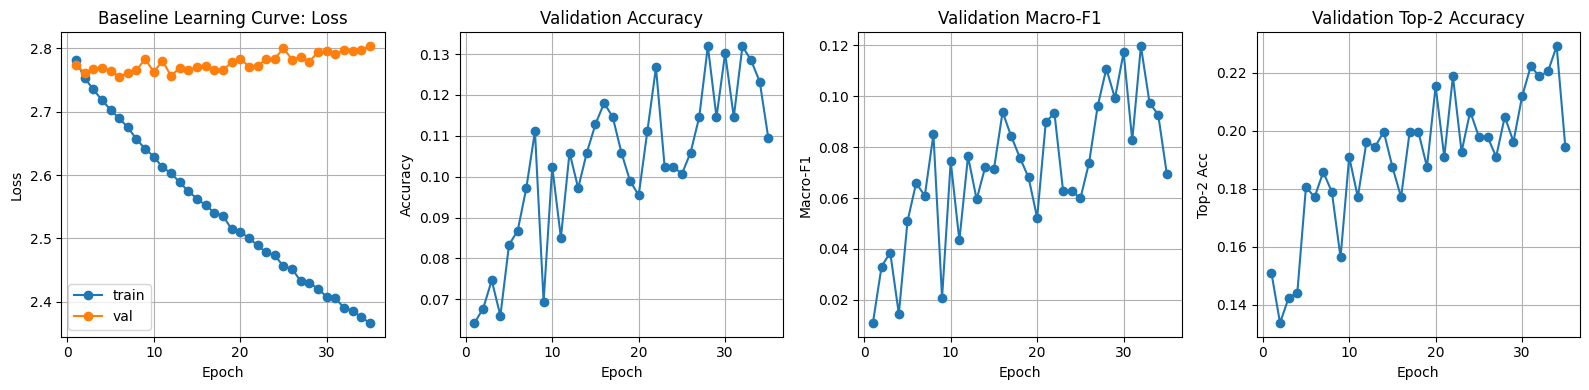

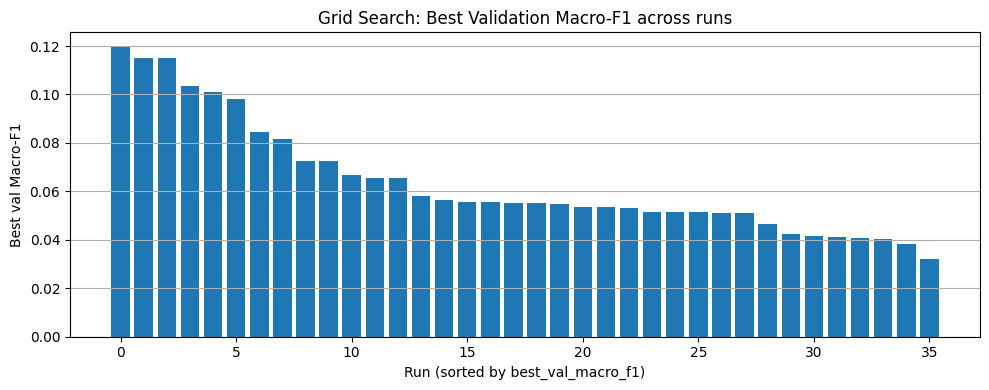


Top-10 runs by best_val_macro_f1:


,run_id,epochs,lr,weight_decay,best_val_macro_f1,sec_total
0,28,35,0.010,0.0000,0.119665,71.986793
1,29,35,0.010,0.0001,0.115222,72.767224
2,30,35,0.010,0.0010,0.115009,72.487617
3,19,20,0.010,0.0000,0.103596,40.834032
4,21,20,0.010,0.0010,0.101015,41.525850
5,20,20,0.010,0.0001,0.098092,41.574903
6,31,35,0.003,0.0000,0.084425,72.424178
7,10,10,0.010,0.0000,0.081547,21.031120
8,33,35,0.003,0.0010,0.072661,72.742836
9,32,35,0.003,0.0001,0.072483,72.010273


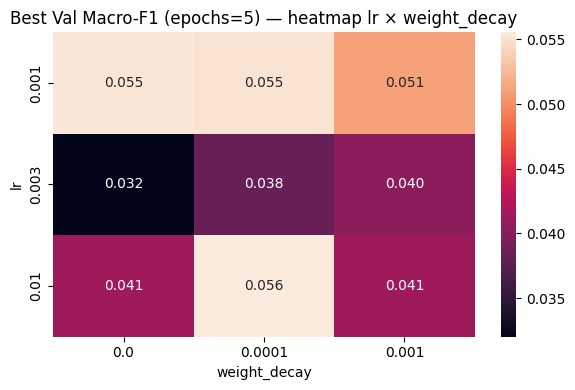

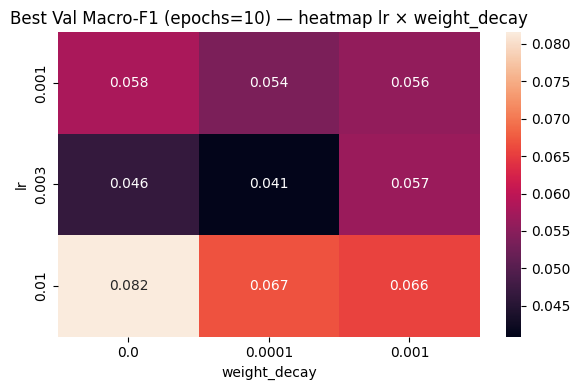

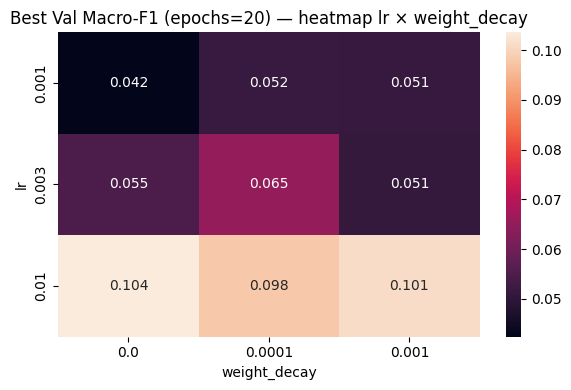

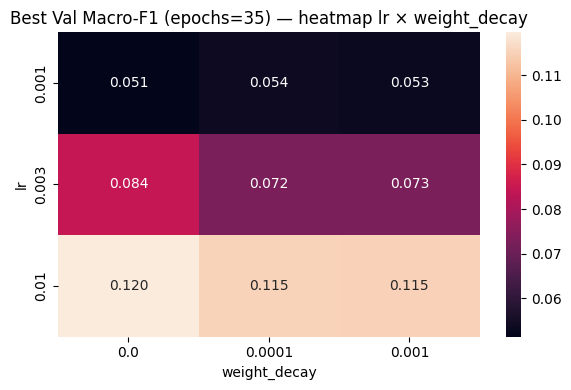

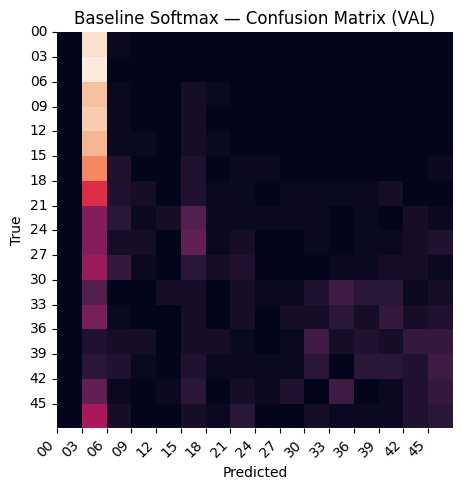

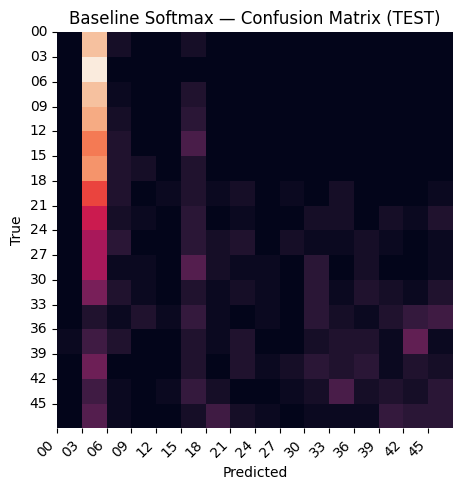

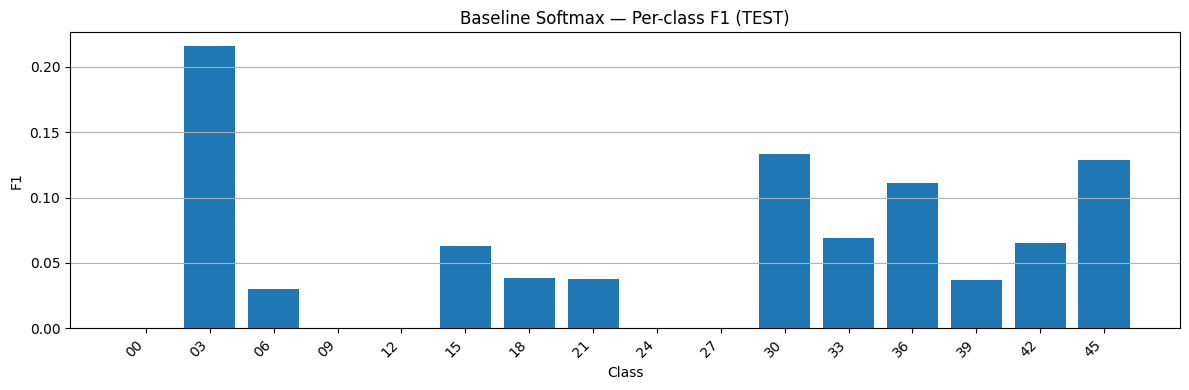

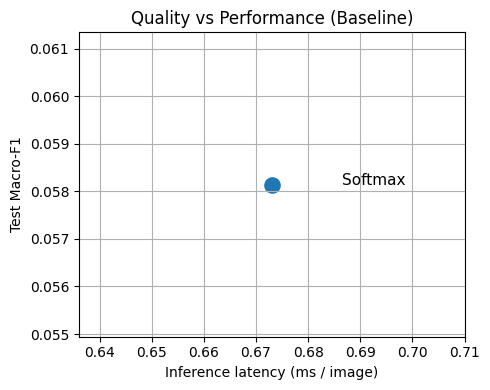


Baseline summary for report:
- Best config: epochs=35, lr=0.01, wd=0.0
- Val: acc=0.1094, macroF1=0.0694, top2=0.1944
- Test: acc=0.1007, macroF1=0.0581, top2=0.2031
- Inference latency: 0.673 ms/img


In [ ]:
# --- Softmax Regression (baseline) report plots ---
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# Optional: seaborn only for nicer heatmaps; if unavailable, we fall back
try:
    import seaborn as sns
    USE_SNS = True
except ImportError:
    USE_SNS = False

# -----------------------------
# Load artifacts
# -----------------------------
assert os.path.exists("results_softmax.csv"), "results_softmax.csv not found. Run grid-search cell first."
assert os.path.exists("checkpoints/softmax_best.pt"), "checkpoints/softmax_best.pt not found. Run grid-search cell first."

df = pd.read_csv("results_softmax.csv")
ckpt = torch.load("checkpoints/softmax_best.pt", map_location="cpu")

history = ckpt["history"]
best_cfg = ckpt["config"]
val_cm = ckpt["val_confusion_matrix"]
test_cm = ckpt["test_confusion_matrix"]
val_metrics = ckpt["val_metrics"]
test_metrics = ckpt["test_metrics"]

# If idx_to_class exists, use it; otherwise make labels 0..15
if "idx_to_class" in ckpt and isinstance(ckpt["idx_to_class"], dict):
    idx_to_class = ckpt["idx_to_class"]
    class_labels = [idx_to_class[i] for i in range(len(idx_to_class))]
else:
    class_labels = [str(i) for i in range(16)]

print("Loaded baseline artifacts.")
print("Best config:", best_cfg)
print("Val metrics:", val_metrics)
print("Test metrics:", test_metrics)

# -----------------------------
# 1) Learning curves for BEST run
# -----------------------------
epochs = np.arange(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(16, 4))

# Loss
plt.subplot(1, 4, 1)
plt.plot(epochs, history["train_loss"], marker="o")
plt.plot(epochs, history["val_loss"], marker="o")
plt.title("Baseline Learning Curve: Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "val"])
plt.grid(True)

# Val Accuracy
plt.subplot(1, 4, 2)
plt.plot(epochs, history["val_acc"], marker="o")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

# Val Macro-F1
plt.subplot(1, 4, 3)
plt.plot(epochs, history["val_macro_f1"], marker="o")
plt.title("Validation Macro-F1")
plt.xlabel("Epoch")
plt.ylabel("Macro-F1")
plt.grid(True)

# Val Top-2
plt.subplot(1, 4, 4)
plt.plot(epochs, history["val_top2_acc"], marker="o")
plt.title("Validation Top-2 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Top-2 Acc")
plt.grid(True)

plt.tight_layout()
plt.show()

# -----------------------------
# 2) Grid search overview (all 36 runs)
# -----------------------------
df_sorted = df.sort_values("best_val_macro_f1", ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 4))
plt.bar(np.arange(len(df_sorted)), df_sorted["best_val_macro_f1"].values)
plt.title("Grid Search: Best Validation Macro-F1 across runs")
plt.xlabel("Run (sorted by best_val_macro_f1)")
plt.ylabel("Best val Macro-F1")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

# Also show which hyperparams correspond to top-10
print("\nTop-10 runs by best_val_macro_f1:")
display(df_sorted.head(10)[["run_id","epochs","lr","weight_decay","best_val_macro_f1","sec_total"]])

# -----------------------------
# 3) Heatmaps: lr x weight_decay for each epochs value
# -----------------------------
unique_epochs = sorted(df["epochs"].unique().tolist())

for ep in unique_epochs:
    sub = df[df["epochs"] == ep].copy()
    pivot = sub.pivot_table(index="lr", columns="weight_decay", values="best_val_macro_f1", aggfunc="mean")
    pivot = pivot.sort_index().sort_index(axis=1)

    plt.figure(figsize=(6, 4))
    if USE_SNS:
        sns.heatmap(pivot, annot=True, fmt=".3f", cbar=True)
        plt.title(f"Best Val Macro-F1 (epochs={ep}) — heatmap lr × weight_decay")
        plt.xlabel("weight_decay")
        plt.ylabel("lr")
        plt.tight_layout()
        plt.show()
    else:
        Z = pivot.values
        lrs = pivot.index.tolist()
        wds = pivot.columns.tolist()

        im = plt.imshow(Z, aspect="auto")
        plt.title(f"Best Val Macro-F1 (epochs={ep}) — lr × weight_decay")
        plt.xlabel("weight_decay")
        plt.ylabel("lr")
        plt.xticks(range(len(wds)), [str(w) for w in wds])
        plt.yticks(range(len(lrs)), [str(l) for l in lrs])

        for i in range(Z.shape[0]):
            for j in range(Z.shape[1]):
                plt.text(j, i, f"{Z[i,j]:.3f}", ha="center", va="center", fontsize=9)

        plt.colorbar(im)
        plt.tight_layout()
        plt.show()

# -----------------------------
# 4) Confusion matrices (val & test) for BEST run
# -----------------------------
def plot_confusion_matrix(cm, title, labels=None):
    cm = cm.numpy() if isinstance(cm, torch.Tensor) else np.array(cm)
    plt.figure(figsize=(6, 5))
    if USE_SNS:
        sns.heatmap(cm, square=True, cbar=False)
    else:
        plt.imshow(cm, aspect="auto")
        plt.colorbar()
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    if labels is not None and len(labels) == cm.shape[0]:
        # show fewer ticks to keep readable
        step = max(1, len(labels)//16)
        ticks = np.arange(0, len(labels), step)
        plt.xticks(ticks, [labels[i] for i in ticks], rotation=45, ha="right")
        plt.yticks(ticks, [labels[i] for i in ticks], rotation=0)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(val_cm, "Baseline Softmax — Confusion Matrix (VAL)", labels=class_labels)
plot_confusion_matrix(test_cm, "Baseline Softmax — Confusion Matrix (TEST)", labels=class_labels)

# -----------------------------
# 5) Per-class F1 on TEST (from confusion matrix)
# -----------------------------
cm = test_cm.float()
tp = torch.diag(cm)
fp = cm.sum(0) - tp
fn = cm.sum(1) - tp
f1 = (2 * tp) / (2 * tp + fp + fn + 1e-12)

plt.figure(figsize=(12, 4))
plt.bar(np.arange(len(f1)), f1.numpy())
plt.title("Baseline Softmax — Per-class F1 (TEST)")
plt.xlabel("Class")
plt.ylabel("F1")
plt.xticks(np.arange(len(f1)), class_labels, rotation=45, ha="right")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

# -----------------------------
# 6) Quality vs Performance (single point for baseline)
# -----------------------------
# You already measured latency_ms_per_image in your benchmark output.
# Put it here manually to store it for report plots.
baseline_latency_ms = 0.673065431944527  # <-- from your benchmark output
baseline_test_macro_f1 = float(test_metrics["macro_f1"])

plt.figure(figsize=(5, 4))
plt.scatter([baseline_latency_ms], [baseline_test_macro_f1], s=120)
plt.text(baseline_latency_ms * 1.02, baseline_test_macro_f1, "Softmax", fontsize=11)
plt.title("Quality vs Performance (Baseline)")
plt.xlabel("Inference latency (ms / image)")
plt.ylabel("Test Macro-F1")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nBaseline summary for report:")
print(f"- Best config: epochs={best_cfg['epochs']}, lr={best_cfg['lr']}, wd={best_cfg['weight_decay']}")
print(f"- Val: acc={val_metrics['acc']:.4f}, macroF1={val_metrics['macro_f1']:.4f}, top2={val_metrics['top2_acc']:.4f}")
print(f"- Test: acc={test_metrics['acc']:.4f}, macroF1={test_metrics['macro_f1']:.4f}, top2={test_metrics['top2_acc']:.4f}")
print(f"- Inference latency: {baseline_latency_ms:.3f} ms/img")


# MLP

In [ ]:
# 5.x Deep MLP with sigmoid (from scratch): deeper grids + manual dropout + input centering + save best
import math
import os, time
import pandas as pd
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 16
D = IMAGE_SIZE * IMAGE_SIZE

os.makedirs("checkpoints", exist_ok=True)

# Loaders
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, num_workers=2)

# ---- helpers ----
def stable_softmax(logits: torch.Tensor) -> torch.Tensor:
    m, _ = torch.max(logits, dim=1, keepdim=True)
    exps = torch.exp(logits - m)
    return exps / torch.sum(exps, dim=1, keepdim=True)

def one_hot(y: torch.Tensor, num_classes: int) -> torch.Tensor:
    oh = torch.zeros((y.size(0), num_classes), device=y.device, dtype=torch.float32)
    oh[torch.arange(y.size(0), device=y.device), y] = 1.0
    return oh

def center_input(x_img: torch.Tensor) -> torch.Tensor:
    # x in [0,1] -> [-1,1] improves sigmoid training stability
    return x_img * 2.0 - 1.0

# ---- layers (from scratch) ----
class LinearScratch:
    def __init__(self, in_dim: int, out_dim: int, seed: int, device: torch.device):
        g = torch.Generator(device="cpu")
        g.manual_seed(seed)
        limit = math.sqrt(6.0 / (in_dim + out_dim))
        self.W = (torch.empty(in_dim, out_dim).uniform_(-limit, limit, generator=g)).to(device)
        self.b = torch.zeros(out_dim, device=device)
        self.x = None
        self.dW = torch.zeros_like(self.W)
        self.db = torch.zeros_like(self.b)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self.x = x
        return x @ self.W + self.b

    def backward(self, dout: torch.Tensor) -> torch.Tensor:
        x = self.x
        self.dW = x.t() @ dout
        self.db = dout.sum(dim=0)
        dx = dout @ self.W.t()
        return dx

    def sgd_step(self, lr: float, weight_decay: float):
        if weight_decay > 0:
            self.dW = self.dW + weight_decay * self.W
        self.W = self.W - lr * self.dW
        self.b = self.b - lr * self.db

class SigmoidScratch:
    def __init__(self):
        self.s = None

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        s = 1.0 / (1.0 + torch.exp(-z))
        self.s = s
        return s

    def backward(self, dout: torch.Tensor) -> torch.Tensor:
        s = self.s
        return dout * s * (1.0 - s)

class DropoutScratch:
    """
    Inverted dropout (from scratch).
    During training: x * mask / (1-p)
    During eval: identity
    """
    def __init__(self, p: float):
        assert 0.0 <= p < 1.0
        self.p = p
        self.mask = None
        self.training = True

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if (not self.training) or self.p == 0.0:
            self.mask = None
            return x
        # mask ~ Bernoulli(1-p)
        keep_prob = 1.0 - self.p
        self.mask = (torch.rand_like(x) < keep_prob).to(x.dtype)
        return x * self.mask / keep_prob

    def backward(self, dout: torch.Tensor) -> torch.Tensor:
        if self.mask is None:
            return dout
        keep_prob = 1.0 - self.p
        return dout * self.mask / keep_prob

class MLPScratch:
    """
    Flatten -> [Linear -> Sigmoid -> (optional Dropout)] x K -> Linear -> logits
    """
    def __init__(self, input_dim: int, hidden_sizes, num_classes: int, dropout_p: float, seed: int, device: torch.device):
        self.hidden_sizes = list(hidden_sizes)
        self.dropout_p = float(dropout_p)
        self.layers = []
        cur = input_dim
        s = seed

        for h in self.hidden_sizes:
            self.layers.append(LinearScratch(cur, h, seed=s, device=device))
            self.layers.append(SigmoidScratch())
            self.layers.append(DropoutScratch(self.dropout_p))  # dropout after activation
            cur = h
            s += 1

        self.out = LinearScratch(cur, num_classes, seed=s, device=device)

    def set_training(self, mode: bool):
        for layer in self.layers:
            if isinstance(layer, DropoutScratch):
                layer.training = mode

    def forward_logits(self, x_img: torch.Tensor) -> torch.Tensor:
        x_img = center_input(x_img)  # <-- key preprocessing for MLP stability
        x = x_img.view(x_img.size(0), -1)
        for layer in self.layers:
            x = layer.forward(x)
        logits = self.out.forward(x)
        return logits

    def train_step(self, x_img: torch.Tensor, y: torch.Tensor, lr: float, weight_decay: float):
        self.set_training(True)
        B = x_img.size(0)

        # forward
        x_img = center_input(x_img)
        x = x_img.view(B, -1)
        for layer in self.layers:
            x = layer.forward(x)
        logits = self.out.forward(x)

        probs = stable_softmax(logits)
        p = probs[torch.arange(B, device=probs.device), y]
        loss = (-torch.log(p + 1e-12)).mean()

        # backward: softmax+CE
        dlogits = (probs - one_hot(y, NUM_CLASSES)) / B
        dx = self.out.backward(dlogits)

        for layer in reversed(self.layers):
            dx = layer.backward(dx)

        # SGD step (weight decay only on Linear weights)
        for layer in self.layers:
            if isinstance(layer, LinearScratch):
                layer.sgd_step(lr=lr, weight_decay=weight_decay)
        self.out.sgd_step(lr=lr, weight_decay=weight_decay)

        return float(loss.item())

    def get_state(self):
        state = {
            "hidden_sizes": self.hidden_sizes,
            "dropout_p": self.dropout_p,
            "layers": [],
            "out": {}
        }
        for layer in self.layers:
            if isinstance(layer, LinearScratch):
                state["layers"].append({"type": "linear", "W": layer.W.detach().cpu(), "b": layer.b.detach().cpu()})
            elif isinstance(layer, SigmoidScratch):
                state["layers"].append({"type": "sigmoid"})
            elif isinstance(layer, DropoutScratch):
                state["layers"].append({"type": "dropout", "p": layer.p})
            else:
                raise ValueError("Unknown layer type")
        state["out"] = {"W": self.out.W.detach().cpu(), "b": self.out.b.detach().cpu()}
        state["input_preprocess"] = "x in [0,1] -> [-1,1] via (2x-1)"
        return state

# ---- training run ----
def train_one_run(hidden_sizes, dropout_p, epochs, lr, weight_decay, seed):
    model = MLPScratch(D, hidden_sizes, NUM_CLASSES, dropout_p=dropout_p, seed=seed, device=device)

    history = {
        "train_loss": [],
        "val_loss": [],
        "val_acc": [],
        "val_macro_f1": [],
        "val_balanced_acc": [],
        "val_top2_acc": [],
        "sec_per_epoch": [],
    }

    t_total0 = time.time()

    for ep in range(1, epochs + 1):
        t0 = time.time()
        loss_sum, n_seen = 0.0, 0

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            l = model.train_step(xb, yb, lr=lr, weight_decay=weight_decay)
            bs = xb.size(0)
            loss_sum += l * bs
            n_seen += bs

        train_loss = loss_sum / n_seen

        # eval
        model.set_training(False)
        forward_fn = lambda x: model.forward_logits(x)
        val_metrics = evaluate_model(val_loader, num_classes=NUM_CLASSES, device=device, forward_fn=forward_fn)

        dt = time.time() - t0

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_metrics["loss"])
        history["val_acc"].append(val_metrics["acc"])
        history["val_macro_f1"].append(val_metrics["macro_f1"])
        history["val_balanced_acc"].append(val_metrics["balanced_acc"])
        history["val_top2_acc"].append(val_metrics["top2_acc"])
        history["sec_per_epoch"].append(dt)

    total_time = time.time() - t_total0
    best_val_macro_f1 = max(history["val_macro_f1"])
    return model, history, total_time, best_val_macro_f1

# ---- grid (deeper MLPs + dropout) ----
hidden_grid = [
    (512, 256),
    (512, 512, 256),
    (1024, 512),
    (1024, 512, 256),
]
dropout_grid = [0.0, 0.3, 0.5]
lr_grid = [1e-3, 3e-4]
wd_grid = [0.0, 1e-4]
epochs_grid = [40, 60]  # keep moderate to save time; already deep nets

runs = []
best = {"score": -1.0, "cfg": None, "model": None, "history": None}

run_id = 0
total_runs = len(hidden_grid)*len(dropout_grid)*len(lr_grid)*len(wd_grid)*len(epochs_grid)

for hidden_sizes in hidden_grid:
    for dropout_p in dropout_grid:
        for lr in lr_grid:
            for wd in wd_grid:
                for epochs in epochs_grid:
                    run_id += 1
                    print(f"\nRun {run_id}/{total_runs} | hidden={hidden_sizes} dropout={dropout_p} epochs={epochs} lr={lr} wd={wd}")
                    model, history, total_time, best_val_macro_f1 = train_one_run(hidden_sizes, dropout_p, epochs, lr, wd, seed=SEED)

                    model.set_training(False)
                    forward_fn = lambda x: model.forward_logits(x)
                    val_last = evaluate_model(val_loader, num_classes=NUM_CLASSES, device=device, forward_fn=forward_fn)

                    runs.append({
                        "run_id": run_id,
                        "hidden_sizes": str(hidden_sizes),
                        "dropout": dropout_p,
                        "epochs": epochs,
                        "lr": lr,
                        "weight_decay": wd,
                        "best_val_macro_f1": best_val_macro_f1,
                        "val_macro_f1_last": val_last["macro_f1"],
                        "val_acc_last": val_last["acc"],
                        "val_balanced_acc_last": val_last["balanced_acc"],
                        "val_loss_last": val_last["loss"],
                        "sec_total": total_time,
                        "sec_per_epoch_avg": sum(history["sec_per_epoch"]) / len(history["sec_per_epoch"]),
                    })

                    if best_val_macro_f1 > best["score"]:
                        best.update({
                            "score": best_val_macro_f1,
                            "cfg": {
                                "hidden_sizes": hidden_sizes,
                                "dropout": dropout_p,
                                "epochs": epochs,
                                "lr": lr,
                                "weight_decay": wd,
                                "seed": SEED,
                                "image_size": IMAGE_SIZE,
                                "input_preprocess": "x in [0,1] -> [-1,1] via (2x-1)"
                            },
                            "model": model,
                            "history": history
                        })

results_df = pd.DataFrame(runs).sort_values(by="best_val_macro_f1", ascending=False).reset_index(drop=True)
display(results_df.head(10))
results_df.to_csv("results_mlp_deep.csv", index=False)
print("\nSaved grid results -> results_mlp_deep.csv")

# ---- eval best ----
best_model = best["model"]
best_model.set_training(False)
best_forward = lambda x: best_model.forward_logits(x)

best_val = evaluate_model(val_loader, num_classes=NUM_CLASSES, device=device, forward_fn=best_forward)
best_test = evaluate_model(test_loader, num_classes=NUM_CLASSES, device=device, forward_fn=best_forward)

print("\nBEST CONFIG:", best["cfg"])
print("Best val metrics:", {k: best_val[k] for k in ["loss","acc","macro_f1","balanced_acc","top2_acc"]})
print("Best test metrics:", {k: best_test[k] for k in ["loss","acc","macro_f1","balanced_acc","top2_acc"]})

# ---- save checkpoint (new name) ----
ckpt = {
    "state": best_model.get_state(),
    "config": best["cfg"],
    "class_to_idx": class_to_idx,
    "idx_to_class": idx_to_class,
    "history": best["history"],
    "val_confusion_matrix": best_val["confusion_matrix"],
    "test_confusion_matrix": best_test["confusion_matrix"],
    "val_metrics": {k: best_val[k] for k in ["loss","acc","macro_f1","balanced_acc","top2_acc"]},
    "test_metrics": {k: best_test[k] for k in ["loss","acc","macro_f1","balanced_acc","top2_acc"]},
}
torch.save(ckpt, "checkpoints/mlp_deep_best.pt")
print("\nSaved checkpoint -> checkpoints/mlp_deep_best.pt")



Run 1/96 | hidden=(512, 256) dropout=0.0 epochs=40 lr=0.001 wd=0.0

Run 2/96 | hidden=(512, 256) dropout=0.0 epochs=60 lr=0.001 wd=0.0

Run 3/96 | hidden=(512, 256) dropout=0.0 epochs=40 lr=0.001 wd=0.0001

Run 4/96 | hidden=(512, 256) dropout=0.0 epochs=60 lr=0.001 wd=0.0001

Run 5/96 | hidden=(512, 256) dropout=0.0 epochs=40 lr=0.0003 wd=0.0

Run 6/96 | hidden=(512, 256) dropout=0.0 epochs=60 lr=0.0003 wd=0.0

Run 7/96 | hidden=(512, 256) dropout=0.0 epochs=40 lr=0.0003 wd=0.0001

Run 8/96 | hidden=(512, 256) dropout=0.0 epochs=60 lr=0.0003 wd=0.0001

Run 9/96 | hidden=(512, 256) dropout=0.3 epochs=40 lr=0.001 wd=0.0

Run 10/96 | hidden=(512, 256) dropout=0.3 epochs=60 lr=0.001 wd=0.0

Run 11/96 | hidden=(512, 256) dropout=0.3 epochs=40 lr=0.001 wd=0.0001

Run 12/96 | hidden=(512, 256) dropout=0.3 epochs=60 lr=0.001 wd=0.0001

Run 13/96 | hidden=(512, 256) dropout=0.3 epochs=40 lr=0.0003 wd=0.0

Run 14/96 | hidden=(512, 256) dropout=0.3 epochs=60 lr=0.0003 wd=0.0

Run 15/96 | hidden

,run_id,hidden_sizes,dropout,epochs,lr,weight_decay,best_val_macro_f1,val_macro_f1_last,val_acc_last,val_balanced_acc_last,val_loss_last,sec_total,sec_per_epoch_avg
0,50,"(1024, 512)",0.0,60,0.001,0.0000,0.141592,0.126661,0.159722,0.159722,2.680670,302.615210,5.043575
1,52,"(1024, 512)",0.0,60,0.001,0.0001,0.141163,0.124099,0.156250,0.156250,2.680700,311.324584,5.188731
2,49,"(1024, 512)",0.0,40,0.001,0.0000,0.140733,0.136508,0.152778,0.152778,2.710229,202.175024,5.054363
3,51,"(1024, 512)",0.0,40,0.001,0.0001,0.140541,0.140541,0.157986,0.157986,2.710241,207.504886,5.187609
4,59,"(1024, 512)",0.3,40,0.001,0.0001,0.139003,0.132727,0.152778,0.152778,2.712389,211.169075,5.279215
5,57,"(1024, 512)",0.3,40,0.001,0.0000,0.137934,0.128410,0.149306,0.149306,2.712400,201.618652,5.040455
6,58,"(1024, 512)",0.3,60,0.001,0.0000,0.133679,0.123527,0.157986,0.157986,2.683907,307.900660,5.131667
7,60,"(1024, 512)",0.3,60,0.001,0.0001,0.133417,0.113847,0.151042,0.151042,2.683899,311.923842,5.198721
8,66,"(1024, 512)",0.5,60,0.001,0.0000,0.128526,0.104537,0.142361,0.142361,2.688083,304.055311,5.067579
9,67,"(1024, 512)",0.5,40,0.001,0.0001,0.126879,0.114641,0.137153,0.137153,2.715344,210.485680,5.262127



Saved grid results -> results_mlp_deep.csv

BEST CONFIG: {'hidden_sizes': (1024, 512), 'dropout': 0.0, 'epochs': 60, 'lr': 0.001, 'weight_decay': 0.0, 'seed': 42, 'image_size': 64, 'input_preprocess': 'x in [0,1] -> [-1,1] via (2x-1)'}
Best val metrics: {'loss': 2.680670420328776, 'acc': 0.1597222238779068, 'macro_f1': 0.12666144967079163, 'balanced_acc': 0.1597222238779068, 'top2_acc': 0.2795138955116272}
Best test metrics: {'loss': 2.6828551822238498, 'acc': 0.1302083283662796, 'macro_f1': 0.10423692315816879, 'balanced_acc': 0.1302083283662796, 'top2_acc': 0.2673611044883728}

Saved checkpoint -> checkpoints/mlp_deep_best.pt


In [ ]:
# Recreate Deep MLP (from scratch) + evaluate_model + retrain best config + save checkpoints/mlp_deep_best.pt

import os, time, math
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 16
D = IMAGE_SIZE * IMAGE_SIZE

os.makedirs("checkpoints", exist_ok=True)

# ---------------- Metrics helpers (needed by evaluate_model) ----------------
@torch.no_grad()
def confusion_matrix_torch(y_true: torch.Tensor, y_pred: torch.Tensor, num_classes: int):
    cm = torch.zeros((num_classes, num_classes), dtype=torch.int64)
    for t, p in zip(y_true.view(-1), y_pred.view(-1)):
        cm[int(t), int(p)] += 1
    return cm

@torch.no_grad()
def accuracy_top1(y_true: torch.Tensor, y_pred: torch.Tensor):
    return (y_true == y_pred).float().mean().item()

@torch.no_grad()
def accuracy_topk(y_true: torch.Tensor, logits: torch.Tensor, k: int = 2):
    topk = torch.topk(logits, k=k, dim=1).indices
    ok = (topk == y_true.view(-1, 1)).any(dim=1).float().mean().item()
    return ok

@torch.no_grad()
def per_class_prf_from_cm(cm: torch.Tensor):
    cm = cm.float()
    tp = torch.diag(cm)
    fp = cm.sum(0) - tp
    fn = cm.sum(1) - tp

    precision = tp / (tp + fp + 1e-12)
    recall    = tp / (tp + fn + 1e-12)
    f1        = 2 * precision * recall / (precision + recall + 1e-12)

    macro_f1 = f1.mean().item()
    balanced_acc = recall.mean().item()

    return {
        "precision_per_class": precision,
        "recall_per_class": recall,
        "f1_per_class": f1,
        "macro_f1": macro_f1,
        "balanced_acc": balanced_acc
    }

# ---------------- Stable CE from logits ----------------
def logsumexp(x: torch.Tensor, dim: int = -1, keepdim: bool = False):
    m, _ = torch.max(x, dim=dim, keepdim=True)
    y = m + torch.log(torch.sum(torch.exp(x - m), dim=dim, keepdim=True))
    return y if keepdim else y.squeeze(dim)

def cross_entropy_from_logits(logits: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    lse = logsumexp(logits, dim=1, keepdim=True)
    log_probs = logits - lse
    nll = -log_probs[torch.arange(logits.size(0), device=logits.device), y]
    return nll.mean()

@torch.no_grad()
def evaluate_model(loader, num_classes: int, device: torch.device, forward_fn, topk: int = 2):
    total_loss = 0.0
    total_n = 0
    all_true, all_pred, all_logits = [], [], []

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)

        logits = forward_fn(xb)
        loss = cross_entropy_from_logits(logits, yb)

        total_loss += float(loss.item()) * xb.size(0)
        total_n += xb.size(0)

        preds = torch.argmax(logits, dim=1)

        all_true.append(yb.detach().cpu())
        all_pred.append(preds.detach().cpu())
        all_logits.append(logits.detach().cpu())

    y_true = torch.cat(all_true, dim=0)
    y_pred = torch.cat(all_pred, dim=0)
    logits_all = torch.cat(all_logits, dim=0)

    cm = confusion_matrix_torch(y_true, y_pred, num_classes=num_classes)
    prf = per_class_prf_from_cm(cm)

    return {
        "loss": total_loss / max(total_n, 1),
        "acc": accuracy_top1(y_true, y_pred),
        "top2_acc": accuracy_topk(y_true, logits_all, k=topk),
        "macro_f1": prf["macro_f1"],
        "balanced_acc": prf["balanced_acc"],
        "confusion_matrix": cm,
        "precision_per_class": prf["precision_per_class"],
        "recall_per_class": prf["recall_per_class"],
        "f1_per_class": prf["f1_per_class"],
    }

# ---------------- Deep MLP from scratch (with sigmoid + optional dropout) ----------------
def stable_softmax(logits: torch.Tensor) -> torch.Tensor:
    m, _ = torch.max(logits, dim=1, keepdim=True)
    exps = torch.exp(logits - m)
    return exps / torch.sum(exps, dim=1, keepdim=True)

def one_hot(y: torch.Tensor, num_classes: int) -> torch.Tensor:
    oh = torch.zeros((y.size(0), num_classes), device=y.device, dtype=torch.float32)
    oh[torch.arange(y.size(0), device=y.device), y] = 1.0
    return oh

def center_input(x_img: torch.Tensor) -> torch.Tensor:
    return x_img * 2.0 - 1.0  # [0,1] -> [-1,1]

class LinearScratch:
    def __init__(self, in_dim: int, out_dim: int, seed: int, device: torch.device):
        g = torch.Generator(device="cpu")
        g.manual_seed(seed)
        limit = math.sqrt(6.0 / (in_dim + out_dim))
        self.W = (torch.empty(in_dim, out_dim).uniform_(-limit, limit, generator=g)).to(device)
        self.b = torch.zeros(out_dim, device=device)
        self.x = None
        self.dW = torch.zeros_like(self.W)
        self.db = torch.zeros_like(self.b)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self.x = x
        return x @ self.W + self.b

    def backward(self, dout: torch.Tensor) -> torch.Tensor:
        x = self.x
        self.dW = x.t() @ dout
        self.db = dout.sum(dim=0)
        dx = dout @ self.W.t()
        return dx

    def sgd_step(self, lr: float, weight_decay: float):
        if weight_decay > 0:
            self.dW = self.dW + weight_decay * self.W
        self.W = self.W - lr * self.dW
        self.b = self.b - lr * self.db

class SigmoidScratch:
    def __init__(self):
        self.s = None

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        s = 1.0 / (1.0 + torch.exp(-z))
        self.s = s
        return s

    def backward(self, dout: torch.Tensor) -> torch.Tensor:
        s = self.s
        return dout * s * (1.0 - s)

class DropoutScratch:
    def __init__(self, p: float):
        self.p = float(p)
        self.mask = None
        self.training = True

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if (not self.training) or self.p == 0.0:
            self.mask = None
            return x
        keep_prob = 1.0 - self.p
        self.mask = (torch.rand_like(x) < keep_prob).to(x.dtype)
        return x * self.mask / keep_prob

    def backward(self, dout: torch.Tensor) -> torch.Tensor:
        if self.mask is None:
            return dout
        keep_prob = 1.0 - self.p
        return dout * self.mask / keep_prob

class MLPScratch:
    def __init__(self, input_dim: int, hidden_sizes, num_classes: int, dropout_p: float, seed: int, device: torch.device):
        self.hidden_sizes = list(hidden_sizes)
        self.dropout_p = float(dropout_p)
        self.layers = []
        cur = input_dim
        s = seed
        for h in self.hidden_sizes:
            self.layers.append(LinearScratch(cur, h, seed=s, device=device))
            self.layers.append(SigmoidScratch())
            self.layers.append(DropoutScratch(self.dropout_p))
            cur = h
            s += 1
        self.out = LinearScratch(cur, num_classes, seed=s, device=device)

    def set_training(self, mode: bool):
        for layer in self.layers:
            if isinstance(layer, DropoutScratch):
                layer.training = mode

    def forward_logits(self, x_img: torch.Tensor) -> torch.Tensor:
        x_img = center_input(x_img)
        x = x_img.view(x_img.size(0), -1)
        for layer in self.layers:
            x = layer.forward(x)
        return self.out.forward(x)

    def train_step(self, x_img: torch.Tensor, y: torch.Tensor, lr: float, weight_decay: float):
        self.set_training(True)
        B = x_img.size(0)

        x_img = center_input(x_img)
        x = x_img.view(B, -1)

        for layer in self.layers:
            x = layer.forward(x)
        logits = self.out.forward(x)

        probs = stable_softmax(logits)
        dlogits = (probs - one_hot(y, NUM_CLASSES)) / B

        # backward
        dx = self.out.backward(dlogits)
        for layer in reversed(self.layers):
            dx = layer.backward(dx)

        # SGD
        for layer in self.layers:
            if isinstance(layer, LinearScratch):
                layer.sgd_step(lr=lr, weight_decay=weight_decay)
        self.out.sgd_step(lr=lr, weight_decay=weight_decay)

        # loss for logging
        p = probs[torch.arange(B, device=probs.device), y]
        loss = (-torch.log(p + 1e-12)).mean()
        return float(loss.item())

    def get_state(self):
        state = {"hidden_sizes": self.hidden_sizes, "dropout_p": self.dropout_p, "layers": [], "out": {}}
        for layer in self.layers:
            if isinstance(layer, LinearScratch):
                state["layers"].append({"type": "linear", "W": layer.W.detach().cpu(), "b": layer.b.detach().cpu()})
            elif isinstance(layer, SigmoidScratch):
                state["layers"].append({"type": "sigmoid"})
            elif isinstance(layer, DropoutScratch):
                state["layers"].append({"type": "dropout", "p": layer.p})
        state["out"] = {"W": self.out.W.detach().cpu(), "b": self.out.b.detach().cpu()}
        state["input_preprocess"] = "x in [0,1] -> [-1,1] via (2x-1)"
        return state

# ---------------- retrain best config and save ----------------
best_cfg = {
    "hidden_sizes": (1024, 512),
    "dropout": 0.0,
    "epochs": 60,
    "lr": 1e-3,
    "weight_decay": 0.0,
    "seed": 42,
    "image_size": IMAGE_SIZE,
    "input_preprocess": "x in [0,1] -> [-1,1] via (2x-1)"
}

print("Retraining Deep MLP best config:", best_cfg)

model = MLPScratch(D, best_cfg["hidden_sizes"], NUM_CLASSES, dropout_p=best_cfg["dropout"], seed=best_cfg["seed"], device=device)

history = {"train_loss": [], "val_loss": [], "val_acc": [], "val_macro_f1": [], "val_balanced_acc": [], "val_top2_acc": [], "sec_per_epoch": []}

for ep in range(1, best_cfg["epochs"] + 1):
    t0 = time.time()
    loss_sum, n_seen = 0.0, 0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        l = model.train_step(xb, yb, lr=best_cfg["lr"], weight_decay=best_cfg["weight_decay"])
        bs = xb.size(0)
        loss_sum += l * bs
        n_seen += bs

    train_loss = loss_sum / n_seen
    model.set_training(False)
    forward_fn = lambda x: model.forward_logits(x)

    val_metrics = evaluate_model(val_loader, num_classes=NUM_CLASSES, device=device, forward_fn=forward_fn)

    dt = time.time() - t0
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_metrics["loss"])
    history["val_acc"].append(val_metrics["acc"])
    history["val_macro_f1"].append(val_metrics["macro_f1"])
    history["val_balanced_acc"].append(val_metrics["balanced_acc"])
    history["val_top2_acc"].append(val_metrics["top2_acc"])
    history["sec_per_epoch"].append(dt)

    print(f"Epoch {ep:02d}/{best_cfg['epochs']} | train_loss={train_loss:.4f} | "
          f"val_acc={val_metrics['acc']:.4f} | val_macroF1={val_metrics['macro_f1']:.4f} | {dt:.2f}s")

# final eval + save
model.set_training(False)
best_forward = lambda x: model.forward_logits(x)
best_val = evaluate_model(val_loader, num_classes=NUM_CLASSES, device=device, forward_fn=best_forward)
best_test = evaluate_model(test_loader, num_classes=NUM_CLASSES, device=device, forward_fn=best_forward)

ckpt = {
    "state": model.get_state(),
    "config": best_cfg,
    "class_to_idx": class_to_idx,
    "idx_to_class": idx_to_class,
    "history": history,
    "val_confusion_matrix": best_val["confusion_matrix"],
    "test_confusion_matrix": best_test["confusion_matrix"],
    "val_metrics": {k: best_val[k] for k in ["loss","acc","macro_f1","balanced_acc","top2_acc"]},
    "test_metrics": {k: best_test[k] for k in ["loss","acc","macro_f1","balanced_acc","top2_acc"]},
}
torch.save(ckpt, "checkpoints/mlp_deep_best.pt")

print("\nSaved -> checkpoints/mlp_deep_best.pt")
print("Val metrics:", {k: best_val[k] for k in ["loss","acc","macro_f1","balanced_acc","top2_acc"]})
print("Test metrics:", {k: best_test[k] for k in ["loss","acc","macro_f1","balanced_acc","top2_acc"]})


Retraining Deep MLP best config: {'hidden_sizes': (1024, 512), 'dropout': 0.0, 'epochs': 60, 'lr': 0.001, 'weight_decay': 0.0, 'seed': 42, 'image_size': 64, 'input_preprocess': 'x in [0,1] -> [-1,1] via (2x-1)'}
Epoch 01/60 | train_loss=2.9019 | val_acc=0.0556 | val_macroF1=0.0105 | 6.66s
Epoch 02/60 | train_loss=2.8063 | val_acc=0.0608 | val_macroF1=0.0316 | 4.14s
Epoch 03/60 | train_loss=2.7739 | val_acc=0.0851 | val_macroF1=0.0661 | 4.01s
Epoch 04/60 | train_loss=2.7594 | val_acc=0.0955 | val_macroF1=0.0816 | 4.53s
Epoch 05/60 | train_loss=2.7505 | val_acc=0.1024 | val_macroF1=0.0892 | 3.89s
Epoch 06/60 | train_loss=2.7430 | val_acc=0.1163 | val_macroF1=0.1063 | 3.70s
Epoch 07/60 | train_loss=2.7361 | val_acc=0.1389 | val_macroF1=0.1332 | 4.36s
Epoch 08/60 | train_loss=2.7294 | val_acc=0.1632 | val_macroF1=0.1473 | 3.60s
Epoch 09/60 | train_loss=2.7227 | val_acc=0.1510 | val_macroF1=0.1327 | 3.61s
Epoch 10/60 | train_loss=2.7164 | val_acc=0.1632 | val_macroF1=0.1397 | 4.50s
Epoch 11

NameError: name 'test_loader' is not defined

In [ ]:
import os, torch

os.makedirs("checkpoints", exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) recreate test_loader if missing
if "test_loader" not in globals():
    print("test_loader is missing. Recreating...")

    if "test_ds" in globals():
        test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2)
        print("Created test_loader from existing test_ds.")
    else:
        # try to recreate from df_splits (common name) and your dataset class
        if "df_splits" in globals() and "RoughnessDataset" in globals():
            df_test = df_splits[df_splits["split"] == "test"].reset_index(drop=True)
            test_ds = RoughnessDataset(df_test, image_size=IMAGE_SIZE)  # adjust args if your Dataset differs
            test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2)
            print("Created test_loader from df_splits via RoughnessDataset.")
        else:
            raise RuntimeError("Cannot recreate test_loader: test_ds is missing and df_splits/RoughnessDataset not found.")

# 2) evaluate test + save checkpoint
model.set_training(False)
best_forward = lambda x: model.forward_logits(x)

best_test = evaluate_model(test_loader, num_classes=NUM_CLASSES, device=device, forward_fn=best_forward)

# val metrics were computed earlier in the previous cell; if not present, recompute quickly:
if "best_val" not in globals():
    best_val = evaluate_model(val_loader, num_classes=NUM_CLASSES, device=device, forward_fn=best_forward)

ckpt = {
    "state": model.get_state(),
    "config": best_cfg,
    "class_to_idx": class_to_idx,
    "idx_to_class": idx_to_class,
    "history": history,
    "val_confusion_matrix": best_val["confusion_matrix"],
    "test_confusion_matrix": best_test["confusion_matrix"],
    "val_metrics": {k: best_val[k] for k in ["loss","acc","macro_f1","balanced_acc","top2_acc"]},
    "test_metrics": {k: best_test[k] for k in ["loss","acc","macro_f1","balanced_acc","top2_acc"]},
}
torch.save(ckpt, "checkpoints/mlp_deep_best.pt")

print("\nSaved -> checkpoints/mlp_deep_best.pt")
print("Val metrics:", {k: best_val[k] for k in ["loss","acc","macro_f1","balanced_acc","top2_acc"]})
print("Test metrics:", {k: best_test[k] for k in ["loss","acc","macro_f1","balanced_acc","top2_acc"]})


test_loader is missing. Recreating...
Created test_loader from existing test_ds.

Saved -> checkpoints/mlp_deep_best.pt
Val metrics: {'loss': 2.509094900555081, 'acc': 0.1788194477558136, 'macro_f1': 0.14714619517326355, 'balanced_acc': 0.1788194328546524, 'top2_acc': 0.3229166567325592}
Test metrics: {'loss': 2.5095048480563693, 'acc': 0.15625, 'macro_f1': 0.11664458364248276, 'balanced_acc': 0.15625, 'top2_acc': 0.2881944477558136}


In [ ]:
# 8.x Performance metrics for Deep MLP + inference benchmark (load from checkpoint)

import torch, time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt_mlp = torch.load("checkpoints/mlp_deep_best.pt", map_location="cpu")
state = ckpt_mlp["state"]
cfg = ckpt_mlp["config"]

NUM_CLASSES = 16
D = IMAGE_SIZE * IMAGE_SIZE

def count_params_mlp_state(state_dict):
    n = 0
    for layer in state_dict["layers"]:
        if layer["type"] == "linear":
            n += layer["W"].numel() + layer["b"].numel()
    n += state_dict["out"]["W"].numel() + state_dict["out"]["b"].numel()
    return n

mlp_params = count_params_mlp_state(state)
mlp_size_mb = mlp_params * 4 / (1024**2)

print("Deep MLP best config:", cfg)
print("Deep MLP params:", mlp_params)
print("Deep MLP model size (MB):", mlp_size_mb)

def mlp_forward_from_state(x_img: torch.Tensor, state_dict):
    # input preprocessing: [0,1] -> [-1,1]
    x_img = x_img * 2.0 - 1.0
    x = x_img.view(x_img.size(0), -1)

    for layer in state_dict["layers"]:
        if layer["type"] == "linear":
            W = layer["W"].to(x.device)
            b = layer["b"].to(x.device)
            x = x @ W + b
        elif layer["type"] == "sigmoid":
            x = 1.0 / (1.0 + torch.exp(-x))
        elif layer["type"] == "dropout":
            # dropout is identity at inference
            pass
        else:
            raise ValueError("Unknown layer type: " + str(layer["type"]))

    Wout = state_dict["out"]["W"].to(x.device)
    bout = state_dict["out"]["b"].to(x.device)
    logits = x @ Wout + bout
    return logits

best_forward_mlp = lambda xb: mlp_forward_from_state(xb, state)

@torch.no_grad()
def benchmark_inference_forward_fn(forward_fn, loader, device, warmup_batches=5, timed_batches=30):
    use_cuda = (device.type == "cuda")
    if use_cuda:
        torch.cuda.reset_peak_memory_stats()

    it = iter(loader)

    for _ in range(warmup_batches):
        try:
            xb, _ = next(it)
        except StopIteration:
            it = iter(loader)
            xb, _ = next(it)
        xb = xb.to(device)
        _ = forward_fn(xb)
        if use_cuda:
            torch.cuda.synchronize()

    n_images = 0
    t0 = time.perf_counter()
    for _ in range(timed_batches):
        try:
            xb, _ = next(it)
        except StopIteration:
            it = iter(loader)
            xb, _ = next(it)
        xb = xb.to(device)
        _ = forward_fn(xb)
        if use_cuda:
            torch.cuda.synchronize()
        n_images += xb.size(0)
    t1 = time.perf_counter()

    total_s = t1 - t0
    throughput = n_images / total_s
    latency_ms = (total_s / n_images) * 1000.0

    peak_mem_mb = None
    if use_cuda:
        peak_mem_mb = torch.cuda.max_memory_allocated() / (1024**2)

    return {
        "latency_ms_per_image": latency_ms,
        "throughput_img_per_s": throughput,
        "total_time_s": total_s,
        "n_images": n_images,
        "peak_gpu_mem_mb": peak_mem_mb
    }

bench_mlp = benchmark_inference_forward_fn(best_forward_mlp, test_loader, device=device, warmup_batches=5, timed_batches=30)

print("\nDeep MLP inference benchmark:")
for k, v in bench_mlp.items():
    print(f"  {k}: {v}")


Deep MLP best config: {'hidden_sizes': (1024, 512), 'dropout': 0.0, 'epochs': 60, 'lr': 0.001, 'weight_decay': 0.0, 'seed': 42, 'image_size': 64, 'input_preprocess': 'x in [0,1] -> [-1,1] via (2x-1)'}
Deep MLP params: 4728336
Deep MLP model size (MB): 18.03717041015625

Deep MLP inference benchmark:
  latency_ms_per_image: 0.7474373029514049
  throughput_img_per_s: 1337.9048597806145
  total_time_s: 4.305238865000092
  n_images: 5760
  peak_gpu_mem_mb: None


Loaded: checkpoints/mlp_deep_best.pt
Config: {'hidden_sizes': (1024, 512), 'dropout': 0.0, 'epochs': 60, 'lr': 0.001, 'weight_decay': 0.0, 'seed': 42, 'image_size': 64, 'input_preprocess': 'x in [0,1] -> [-1,1] via (2x-1)'}
Val metrics: {'loss': 2.509094900555081, 'acc': 0.1788194477558136, 'macro_f1': 0.14714619517326355, 'balanced_acc': 0.1788194328546524, 'top2_acc': 0.3229166567325592}
Test metrics: {'loss': 2.5095048480563693, 'acc': 0.15625, 'macro_f1': 0.11664458364248276, 'balanced_acc': 0.15625, 'top2_acc': 0.2881944477558136}


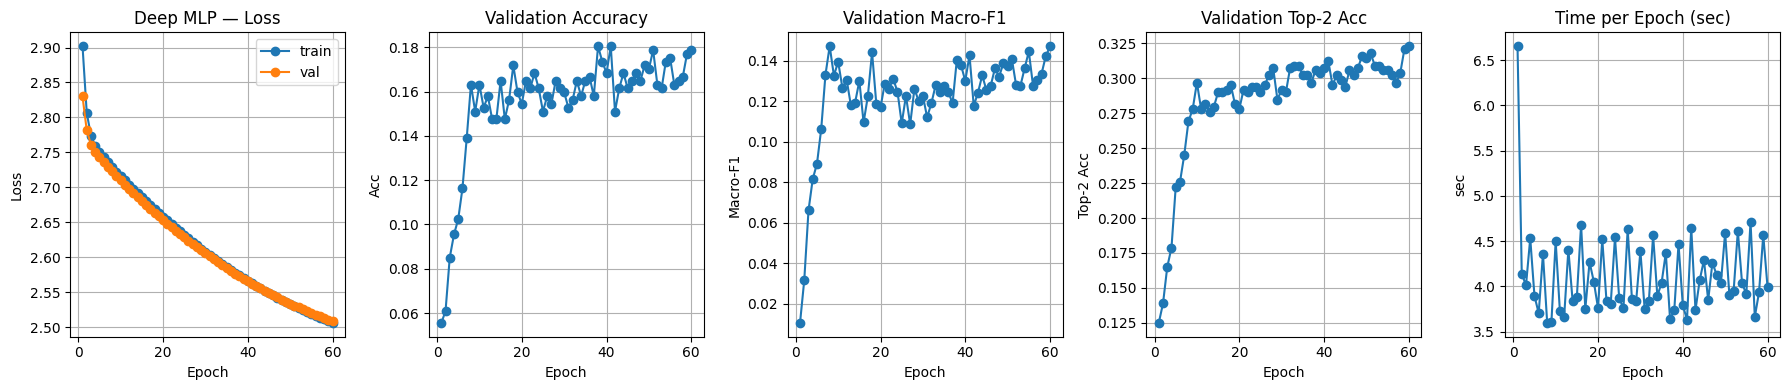

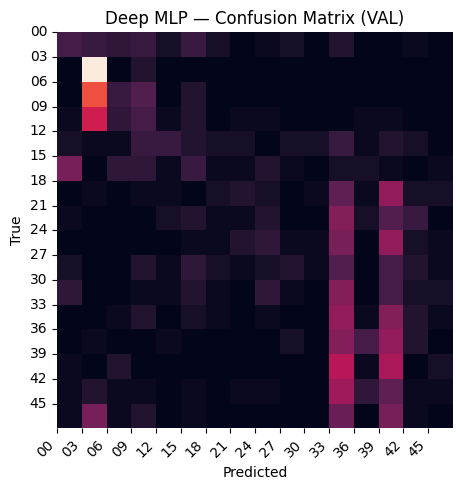

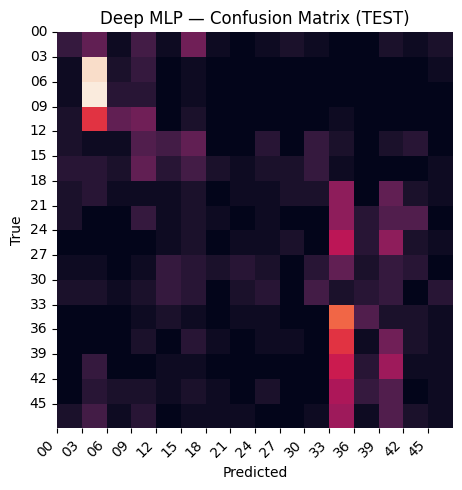

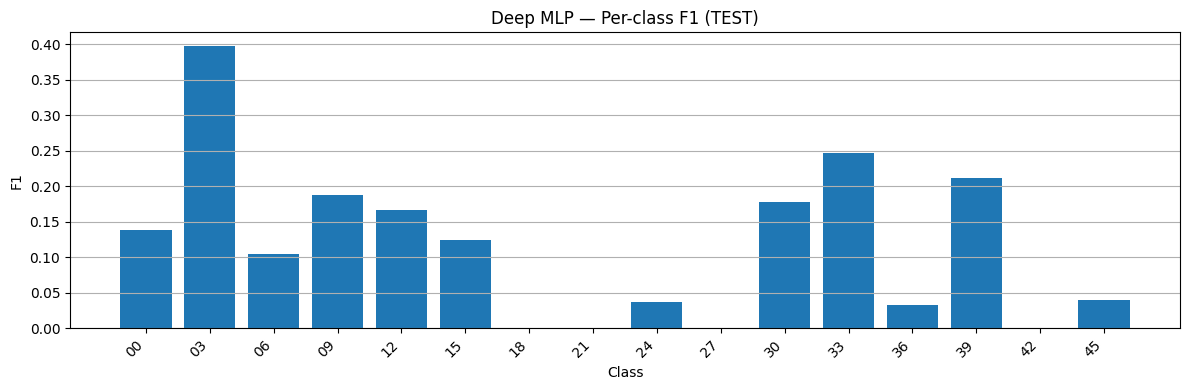

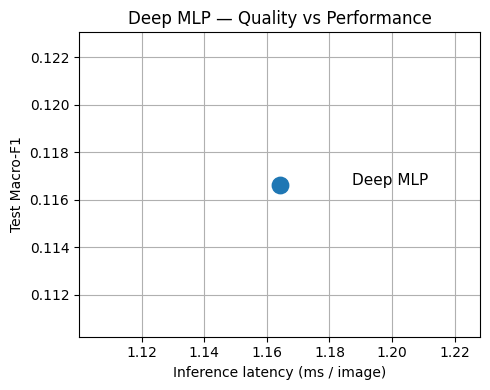


Deep MLP inference benchmark: {'latency_ms_per_image': 1.1640413701387489, 'throughput_img_per_s': 859.0759964835306, 'total_time_s': 6.704878291999194, 'n_images': 5760, 'peak_gpu_mem_mb': None}

Deep MLP summary (copy into report):
- Config: {'hidden_sizes': (1024, 512), 'dropout': 0.0, 'epochs': 60, 'lr': 0.001, 'weight_decay': 0.0, 'seed': 42, 'image_size': 64, 'input_preprocess': 'x in [0,1] -> [-1,1] via (2x-1)'}
- Val: acc=0.1788, macroF1=0.1471, top2=0.3229
- Test: acc=0.1562, macroF1=0.1166, top2=0.2882
- Inference: latency=1.164 ms/img, throughput=859.1 img/s


In [ ]:
# --- Deep MLP (from scratch) report plots from checkpoints/mlp_deep_best.pt ---
import os, time
import numpy as np
import torch
import matplotlib.pyplot as plt

# Optional seaborn for nicer plots
try:
    import seaborn as sns
    USE_SNS = True
except ImportError:
    USE_SNS = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt_path = "checkpoints/mlp_deep_best.pt"
assert os.path.exists(ckpt_path), f"Checkpoint not found: {ckpt_path}"

ckpt = torch.load(ckpt_path, map_location="cpu")
cfg = ckpt.get("config", {})
hist = ckpt.get("history", {})
state = ckpt.get("state", None)

val_cm = ckpt.get("val_confusion_matrix", None)
test_cm = ckpt.get("test_confusion_matrix", None)
val_metrics = ckpt.get("val_metrics", {})
test_metrics = ckpt.get("test_metrics", {})

# class labels
if "idx_to_class" in ckpt and isinstance(ckpt["idx_to_class"], dict):
    idx_to_class = ckpt["idx_to_class"]
    class_labels = [idx_to_class[i] for i in range(len(idx_to_class))]
else:
    class_labels = [str(i) for i in range(16)]

print("Loaded:", ckpt_path)
print("Config:", cfg)
print("Val metrics:", val_metrics)
print("Test metrics:", test_metrics)

# -----------------------------
# Forward from saved state (inference only)
# -----------------------------
def mlp_forward_from_state(x_img: torch.Tensor, state_dict):
    # preprocessing used in your deep MLP
    x_img = x_img * 2.0 - 1.0  # [0,1] -> [-1,1]
    x = x_img.view(x_img.size(0), -1)

    for layer in state_dict["layers"]:
        t = layer["type"]
        if t == "linear":
            W = layer["W"].to(x.device)
            b = layer["b"].to(x.device)
            x = x @ W + b
        elif t == "sigmoid":
            x = 1.0 / (1.0 + torch.exp(-x))
        elif t == "dropout":
            # dropout is identity at inference
            pass
        else:
            raise ValueError("Unknown layer type: " + str(t))

    Wout = state_dict["out"]["W"].to(x.device)
    bout = state_dict["out"]["b"].to(x.device)
    logits = x @ Wout + bout
    return logits

@torch.no_grad()
def benchmark_inference_forward_fn(forward_fn, loader, device, warmup_batches=5, timed_batches=30):
    use_cuda = (device.type == "cuda")
    if use_cuda:
        torch.cuda.reset_peak_memory_stats()

    it = iter(loader)

    # warmup
    for _ in range(warmup_batches):
        try:
            xb, _ = next(it)
        except StopIteration:
            it = iter(loader)
            xb, _ = next(it)
        xb = xb.to(device)
        _ = forward_fn(xb)
        if use_cuda:
            torch.cuda.synchronize()

    # timed
    n_images = 0
    t0 = time.perf_counter()
    for _ in range(timed_batches):
        try:
            xb, _ = next(it)
        except StopIteration:
            it = iter(loader)
            xb, _ = next(it)
        xb = xb.to(device)
        _ = forward_fn(xb)
        if use_cuda:
            torch.cuda.synchronize()
        n_images += xb.size(0)

    t1 = time.perf_counter()
    total_s = t1 - t0
    throughput = n_images / total_s
    latency_ms = (total_s / n_images) * 1000.0

    peak_mem_mb = None
    if use_cuda:
        peak_mem_mb = torch.cuda.max_memory_allocated() / (1024**2)

    return {
        "latency_ms_per_image": latency_ms,
        "throughput_img_per_s": throughput,
        "total_time_s": total_s,
        "n_images": n_images,
        "peak_gpu_mem_mb": peak_mem_mb
    }

def plot_confusion(cm, title, labels=None):
    cm = cm.numpy() if isinstance(cm, torch.Tensor) else np.array(cm)
    plt.figure(figsize=(6,5))
    if USE_SNS:
        sns.heatmap(cm, square=True, cbar=False)
    else:
        plt.imshow(cm, aspect="auto")
        plt.colorbar()
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    if labels is not None and len(labels) == cm.shape[0]:
        step = max(1, len(labels)//16)
        ticks = np.arange(0, len(labels), step)
        plt.xticks(ticks, [labels[i] for i in ticks], rotation=45, ha="right")
        plt.yticks(ticks, [labels[i] for i in ticks], rotation=0)
    plt.tight_layout()
    plt.show()

# -----------------------------
# 1) Learning curves (best run)
# -----------------------------
if "train_loss" in hist and len(hist["train_loss"]) > 0:
    epochs = np.arange(1, len(hist["train_loss"]) + 1)

    plt.figure(figsize=(18,4))

    # loss
    plt.subplot(1,5,1)
    plt.plot(epochs, hist["train_loss"], marker="o")
    plt.plot(epochs, hist["val_loss"], marker="o")
    plt.title("Deep MLP — Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["train", "val"])
    plt.grid(True)

    # val acc
    plt.subplot(1,5,2)
    plt.plot(epochs, hist["val_acc"], marker="o")
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Acc")
    plt.grid(True)

    # val macro f1
    plt.subplot(1,5,3)
    plt.plot(epochs, hist["val_macro_f1"], marker="o")
    plt.title("Validation Macro-F1")
    plt.xlabel("Epoch")
    plt.ylabel("Macro-F1")
    plt.grid(True)

    # val top2
    plt.subplot(1,5,4)
    if "val_top2_acc" in hist:
        plt.plot(epochs, hist["val_top2_acc"], marker="o")
    plt.title("Validation Top-2 Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Top-2 Acc")
    plt.grid(True)

    # epoch time
    plt.subplot(1,5,5)
    if "sec_per_epoch" in hist:
        plt.plot(epochs, hist["sec_per_epoch"], marker="o")
    plt.title("Time per Epoch (sec)")
    plt.xlabel("Epoch")
    plt.ylabel("sec")
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("No learning curves in checkpoint (history missing).")

# -----------------------------
# 2) Confusion matrices
# -----------------------------
if val_cm is not None:
    plot_confusion(val_cm, "Deep MLP — Confusion Matrix (VAL)", class_labels)
if test_cm is not None:
    plot_confusion(test_cm, "Deep MLP — Confusion Matrix (TEST)", class_labels)

# -----------------------------
# 3) Per-class F1 on TEST
# -----------------------------
if test_cm is not None:
    cm = test_cm.float()
    tp = torch.diag(cm)
    fp = cm.sum(0) - tp
    fn = cm.sum(1) - tp
    f1 = (2 * tp) / (2 * tp + fp + fn + 1e-12)

    plt.figure(figsize=(12,4))
    plt.bar(np.arange(len(f1)), f1.numpy())
    plt.title("Deep MLP — Per-class F1 (TEST)")
    plt.xlabel("Class")
    plt.ylabel("F1")
    plt.xticks(np.arange(len(f1)), class_labels, rotation=45, ha="right")
    plt.grid(True, axis="y")
    plt.tight_layout()
    plt.show()

# -----------------------------
# 4) Quality vs Performance: benchmark inference from saved weights
# -----------------------------
assert state is not None, "Checkpoint does not contain 'state' (needed for forward-from-state)."
assert "test_loader" in globals(), "test_loader is not defined in this runtime. Run the DataLoader cell first."

forward_fn = lambda xb: mlp_forward_from_state(xb, state)
bench = benchmark_inference_forward_fn(forward_fn, test_loader, device=device, warmup_batches=5, timed_batches=30)

lat = bench["latency_ms_per_image"]
macro_f1 = float(test_metrics.get("macro_f1", np.nan))

plt.figure(figsize=(5,4))
plt.scatter([lat], [macro_f1], s=140)
plt.text(lat*1.02, macro_f1, "Deep MLP", fontsize=11)
plt.title("Deep MLP — Quality vs Performance")
plt.xlabel("Inference latency (ms / image)")
plt.ylabel("Test Macro-F1")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nDeep MLP inference benchmark:", bench)

# -----------------------------
# 5) Small summary block for report
# -----------------------------
print("\nDeep MLP summary (copy into report):")
print("- Config:", cfg)
print(f"- Val: acc={val_metrics.get('acc', float('nan')):.4f}, macroF1={val_metrics.get('macro_f1', float('nan')):.4f}, top2={val_metrics.get('top2_acc', float('nan')):.4f}")
print(f"- Test: acc={test_metrics.get('acc', float('nan')):.4f}, macroF1={test_metrics.get('macro_f1', float('nan')):.4f}, top2={test_metrics.get('top2_acc', float('nan')):.4f}")
print(f"- Inference: latency={lat:.3f} ms/img, throughput={bench['throughput_img_per_s']:.1f} img/s")


Reconstructed TOP-10 grid-search results (from pasted output):


,run_id,hidden_sizes,dropout,epochs,lr,weight_decay,best_val_macro_f1,val_macro_f1_last,val_acc_last,val_balanced_acc_last,val_loss_last,sec_total,sec_per_epoch_avg
0,50,"(1024, 512)",0.0,60,0.001,0.0000,0.141592,0.126661,0.159722,0.159722,2.680670,302.615210,5.043575
1,52,"(1024, 512)",0.0,60,0.001,0.0001,0.141163,0.124099,0.156250,0.156250,2.680700,311.324584,5.188731
2,49,"(1024, 512)",0.0,40,0.001,0.0000,0.140733,0.136508,0.152778,0.152778,2.710229,202.175024,5.054363
3,51,"(1024, 512)",0.0,40,0.001,0.0001,0.140541,0.140541,0.157986,0.157986,2.710241,207.504886,5.187609
4,59,"(1024, 512)",0.3,40,0.001,0.0001,0.139003,0.132727,0.152778,0.152778,2.712389,211.169075,5.279215
5,57,"(1024, 512)",0.3,40,0.001,0.0000,0.137934,0.128410,0.149306,0.149306,2.712400,201.618652,5.040455
6,58,"(1024, 512)",0.3,60,0.001,0.0000,0.133679,0.123527,0.157986,0.157986,2.683907,307.900660,5.131667
7,60,"(1024, 512)",0.3,60,0.001,0.0001,0.133417,0.113847,0.151042,0.151042,2.683899,311.923842,5.198721
8,66,"(1024, 512)",0.5,60,0.001,0.0000,0.128526,0.104537,0.142361,0.142361,2.688083,304.055311,5.067579
9,67,"(1024, 512)",0.5,40,0.001,0.0001,0.126879,0.114641,0.137153,0.137153,2.715344,210.485680,5.262127



BEST CONFIG (from output): {'hidden_sizes': (1024, 512), 'dropout': 0.0, 'epochs': 60, 'lr': 0.001, 'weight_decay': 0.0, 'seed': 42, 'image_size': 64, 'input_preprocess': 'x in [0,1] -> [-1,1] via (2x-1)'}
Best VAL metrics: {'loss': 2.680670420328776, 'acc': 0.1597222238779068, 'macro_f1': 0.12666144967079163, 'balanced_acc': 0.1597222238779068, 'top2_acc': 0.2795138955116272}
Best TEST metrics: {'loss': 2.6828551822238498, 'acc': 0.1302083283662796, 'macro_f1': 0.10423692315816879, 'balanced_acc': 0.1302083283662796, 'top2_acc': 0.2673611044883728}


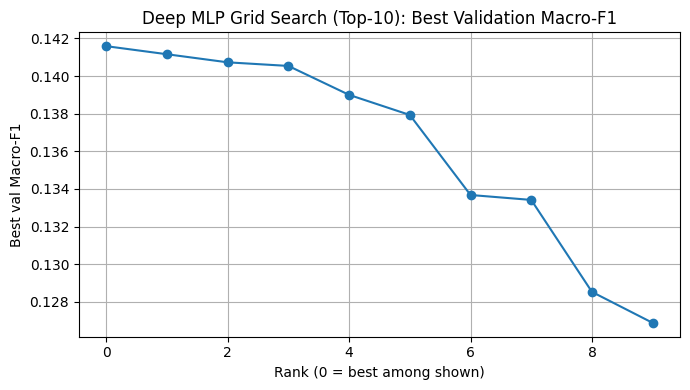

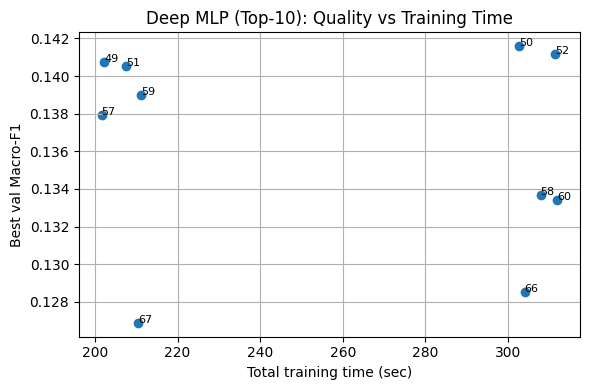

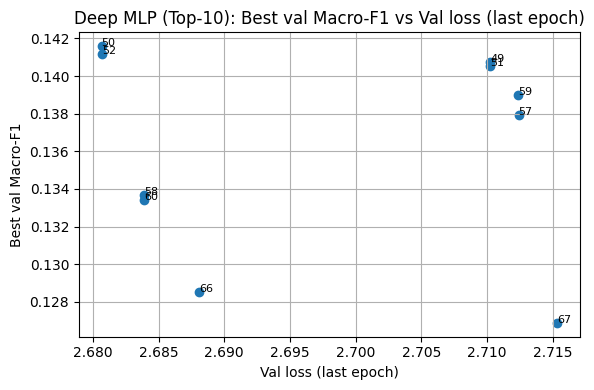

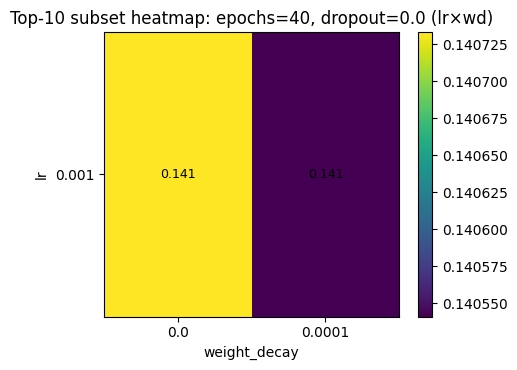

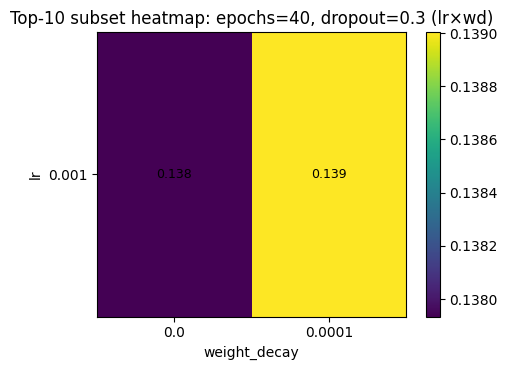

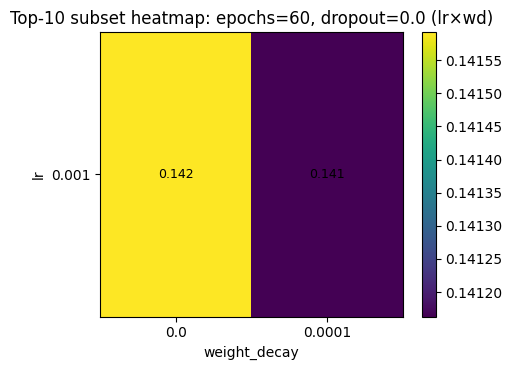

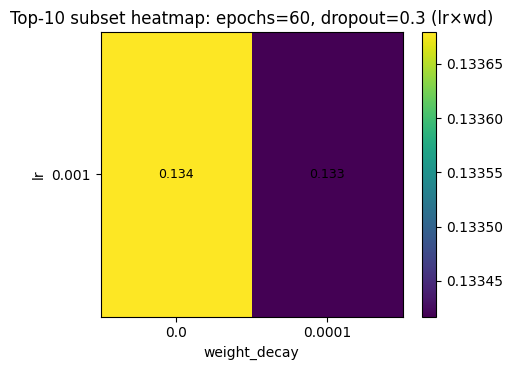


Top-10 summary table (copy into report):


,run_id,hidden_sizes,dropout,epochs,lr,weight_decay,best_val_macro_f1,sec_total
0,50,"(1024, 512)",0.0,60,0.001,0.0000,0.141592,302.615210
1,52,"(1024, 512)",0.0,60,0.001,0.0001,0.141163,311.324584
2,49,"(1024, 512)",0.0,40,0.001,0.0000,0.140733,202.175024
3,51,"(1024, 512)",0.0,40,0.001,0.0001,0.140541,207.504886
4,59,"(1024, 512)",0.3,40,0.001,0.0001,0.139003,211.169075
5,57,"(1024, 512)",0.3,40,0.001,0.0000,0.137934,201.618652
6,58,"(1024, 512)",0.3,60,0.001,0.0000,0.133679,307.900660
7,60,"(1024, 512)",0.3,60,0.001,0.0001,0.133417,311.923842
8,66,"(1024, 512)",0.5,60,0.001,0.0000,0.128526,304.055311
9,67,"(1024, 512)",0.5,40,0.001,0.0001,0.126879,210.485680


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Reconstruct "top-10" grid search table from your pasted output
# -----------------------------
rows = [
    # run_id, hidden_sizes, dropout, epochs, lr, weight_decay, best_val_macro_f1,
    # val_macro_f1_last, val_acc_last, val_balanced_acc_last, val_loss_last, sec_total, sec_per_epoch_avg
    (50, "(1024, 512)", 0.0, 60, 0.001, 0.0,    0.141592, 0.126661, 0.159722, 0.159722, 2.680670, 302.615210, 5.043575),
    (52, "(1024, 512)", 0.0, 60, 0.001, 0.0001, 0.141163, 0.124099, 0.156250, 0.156250, 2.680700, 311.324584, 5.188731),
    (49, "(1024, 512)", 0.0, 40, 0.001, 0.0,    0.140733, 0.136508, 0.152778, 0.152778, 2.710229, 202.175024, 5.054363),
    (51, "(1024, 512)", 0.0, 40, 0.001, 0.0001, 0.140541, 0.140541, 0.157986, 0.157986, 2.710241, 207.504886, 5.187609),
    (59, "(1024, 512)", 0.3, 40, 0.001, 0.0001, 0.139003, 0.132727, 0.152778, 0.152778, 2.712389, 211.169075, 5.279215),
    (57, "(1024, 512)", 0.3, 40, 0.001, 0.0,    0.137934, 0.128410, 0.149306, 0.149306, 2.712400, 201.618652, 5.040455),
    (58, "(1024, 512)", 0.3, 60, 0.001, 0.0,    0.133679, 0.123527, 0.157986, 0.157986, 2.683907, 307.900660, 5.131667),
    (60, "(1024, 512)", 0.3, 60, 0.001, 0.0001, 0.133417, 0.113847, 0.151042, 0.151042, 2.683899, 311.923842, 5.198721),
    (66, "(1024, 512)", 0.5, 60, 0.001, 0.0,    0.128526, 0.104537, 0.142361, 0.142361, 2.688083, 304.055311, 5.067579),
    (67, "(1024, 512)", 0.5, 40, 0.001, 0.0001, 0.126879, 0.114641, 0.137153, 0.137153, 2.715344, 210.485680, 5.262127),
]

df_top10 = pd.DataFrame(rows, columns=[
    "run_id","hidden_sizes","dropout","epochs","lr","weight_decay","best_val_macro_f1",
    "val_macro_f1_last","val_acc_last","val_balanced_acc_last","val_loss_last","sec_total","sec_per_epoch_avg"
])

best_cfg = {
    "hidden_sizes": (1024, 512),
    "dropout": 0.0,
    "epochs": 60,
    "lr": 0.001,
    "weight_decay": 0.0,
    "seed": 42,
    "image_size": 64,
    "input_preprocess": "x in [0,1] -> [-1,1] via (2x-1)"
}

best_val_metrics = {
    "loss": 2.680670420328776,
    "acc": 0.1597222238779068,
    "macro_f1": 0.12666144967079163,
    "balanced_acc": 0.1597222238779068,
    "top2_acc": 0.2795138955116272
}

best_test_metrics = {
    "loss": 2.6828551822238498,
    "acc": 0.1302083283662796,
    "macro_f1": 0.10423692315816879,
    "balanced_acc": 0.1302083283662796,
    "top2_acc": 0.2673611044883728
}

print("Reconstructed TOP-10 grid-search results (from pasted output):")
display(df_top10)

print("\nBEST CONFIG (from output):", best_cfg)
print("Best VAL metrics:", best_val_metrics)
print("Best TEST metrics:", best_test_metrics)

# -----------------------------
# 1) Ranking plot: best_val_macro_f1 (top-10 shown)
# -----------------------------
df_rank = df_top10.sort_values("best_val_macro_f1", ascending=False).reset_index(drop=True)

plt.figure(figsize=(7,4))
plt.plot(df_rank["best_val_macro_f1"].values, marker="o")
plt.title("Deep MLP Grid Search (Top-10): Best Validation Macro-F1")
plt.xlabel("Rank (0 = best among shown)")
plt.ylabel("Best val Macro-F1")
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# 2) Scatter: sec_total vs best_val_macro_f1 (quality vs time)
# -----------------------------
plt.figure(figsize=(6,4))
plt.scatter(df_top10["sec_total"], df_top10["best_val_macro_f1"])
for _, r in df_top10.iterrows():
    plt.text(r["sec_total"], r["best_val_macro_f1"], str(int(r["run_id"])), fontsize=8)
plt.title("Deep MLP (Top-10): Quality vs Training Time")
plt.xlabel("Total training time (sec)")
plt.ylabel("Best val Macro-F1")
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# 3) Scatter: val_loss_last vs best_val_macro_f1
# -----------------------------
plt.figure(figsize=(6,4))
plt.scatter(df_top10["val_loss_last"], df_top10["best_val_macro_f1"])
for _, r in df_top10.iterrows():
    plt.text(r["val_loss_last"], r["best_val_macro_f1"], str(int(r["run_id"])), fontsize=8)
plt.title("Deep MLP (Top-10): Best val Macro-F1 vs Val loss (last epoch)")
plt.xlabel("Val loss (last epoch)")
plt.ylabel("Best val Macro-F1")
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# 4) Heatmaps from TOP-10 subset (epochs=40 and epochs=60), dropout-specific
#    Note: this is only the top-10 subset, not all 96 runs.
# -----------------------------
def heatmap_from_subset(df_sub, title):
    pivot = df_sub.pivot_table(index="lr", columns="weight_decay", values="best_val_macro_f1", aggfunc="mean")
    pivot = pivot.sort_index().sort_index(axis=1)

    Z = pivot.values
    lrs = pivot.index.tolist()
    wds = pivot.columns.tolist()

    plt.figure(figsize=(5,3.8))
    im = plt.imshow(Z, aspect="auto")
    plt.title(title)
    plt.xlabel("weight_decay")
    plt.ylabel("lr")
    plt.xticks(range(len(wds)), [str(w) for w in wds])
    plt.yticks(range(len(lrs)), [str(l) for l in lrs])

    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            if np.isfinite(Z[i,j]):
                plt.text(j, i, f"{Z[i,j]:.3f}", ha="center", va="center", fontsize=9)

    plt.colorbar(im)
    plt.tight_layout()
    plt.show()

for ep in sorted(df_top10["epochs"].unique()):
    for d in sorted(df_top10["dropout"].unique()):
        sub = df_top10[(df_top10["epochs"] == ep) & (df_top10["dropout"] == d)]
        if len(sub) >= 2:
            heatmap_from_subset(sub, f"Top-10 subset heatmap: epochs={ep}, dropout={d} (lr×wd)")

# -----------------------------
# 5) Small report table (top-10 summary)
# -----------------------------
summary_cols = ["run_id","hidden_sizes","dropout","epochs","lr","weight_decay","best_val_macro_f1","sec_total"]
print("\nTop-10 summary table (copy into report):")
display(df_rank[summary_cols])


# CNN

In [ ]:
# 6.x CNN (PyTorch layers allowed): model + train/eval loop (one full config)

import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 16

class CNNModel(nn.Module):
    def __init__(self, channels=(32,64,128), dropout=0.5):
        super().__init__()
        c1, c2, c3 = channels

        self.features = nn.Sequential(
            nn.Conv2d(1, c1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(c1, c2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(c2, c3, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # input 64x64 -> after 3 pools: 8x8
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(c3 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, NUM_CLASSES)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

def train_cnn_one_run(cfg):
    model = CNNModel(channels=cfg["channels"], dropout=cfg["dropout"]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])

    history = {
        "train_loss": [], "val_loss": [],
        "val_acc": [], "val_macro_f1": [], "val_balanced_acc": [], "val_top2_acc": [],
        "sec_per_epoch": []
    }

    best_state = None
    best_score = -1.0
    best_epoch = -1
    patience = cfg.get("patience", 8)
    bad_epochs = 0

    for ep in range(1, cfg["epochs"] + 1):
        t0 = time.time()
        model.train()

        loss_sum, n_seen = 0.0, 0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            bs = xb.size(0)
            loss_sum += float(loss.item()) * bs
            n_seen += bs

        train_loss = loss_sum / n_seen

        val_metrics = evaluate_model(val_loader, num_classes=NUM_CLASSES, device=device, model=model)

        dt = time.time() - t0

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_metrics["loss"])
        history["val_acc"].append(val_metrics["acc"])
        history["val_macro_f1"].append(val_metrics["macro_f1"])
        history["val_balanced_acc"].append(val_metrics["balanced_acc"])
        history["val_top2_acc"].append(val_metrics["top2_acc"])
        history["sec_per_epoch"].append(dt)

        score = val_metrics["macro_f1"]
        print(f"Epoch {ep:02d}/{cfg['epochs']} | train_loss={train_loss:.4f} | "
              f"val_loss={val_metrics['loss']:.4f} | val_acc={val_metrics['acc']:.4f} | "
              f"val_macroF1={val_metrics['macro_f1']:.4f} | time={dt:.2f}s")

        # early stopping on macro-F1
        if score > best_score:
            best_score = score
            best_epoch = ep
            best_state = copy.deepcopy(model.state_dict())
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                print(f"Early stopping: no improvement for {patience} epochs. Best epoch={best_epoch}, best_macroF1={best_score:.4f}")
                break

    # load best
    model.load_state_dict(best_state)
    return model, history, best_score, best_epoch

# One solid default config (we'll grid-search next)
cnn_cfg = {
    "channels": (32, 64, 128),
    "dropout": 0.5,
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "epochs": 60,
    "patience": 8,
}

cnn_model, cnn_history, cnn_best_score, cnn_best_epoch = train_cnn_one_run(cnn_cfg)

# Final val/test eval for this run
val_metrics = evaluate_model(val_loader, num_classes=NUM_CLASSES, device=device, model=cnn_model)
test_metrics = evaluate_model(test_loader, num_classes=NUM_CLASSES, device=device, model=cnn_model)

print("\nCNN run config:", cnn_cfg)
print("Best val macro-F1 during training:", cnn_best_score, "at epoch", cnn_best_epoch)
print("Val metrics:", {k: val_metrics[k] for k in ["loss","acc","macro_f1","balanced_acc","top2_acc"]})
print("Test metrics:", {k: test_metrics[k] for k in ["loss","acc","macro_f1","balanced_acc","top2_acc"]})


Epoch 01/60 | train_loss=2.6815 | val_loss=2.3571 | val_acc=0.1667 | val_macroF1=0.0818 | time=37.62s
Epoch 02/60 | train_loss=2.2045 | val_loss=1.8968 | val_acc=0.2812 | val_macroF1=0.2116 | time=35.65s
Epoch 03/60 | train_loss=1.7949 | val_loss=1.5564 | val_acc=0.3438 | val_macroF1=0.2960 | time=36.49s
Epoch 04/60 | train_loss=1.5854 | val_loss=1.4234 | val_acc=0.4549 | val_macroF1=0.4229 | time=36.82s
Epoch 05/60 | train_loss=1.4447 | val_loss=1.5043 | val_acc=0.3715 | val_macroF1=0.3318 | time=38.37s
Epoch 06/60 | train_loss=1.4028 | val_loss=1.3465 | val_acc=0.4635 | val_macroF1=0.4414 | time=35.77s
Epoch 07/60 | train_loss=1.2092 | val_loss=1.1678 | val_acc=0.5503 | val_macroF1=0.5408 | time=37.86s
Epoch 08/60 | train_loss=1.1592 | val_loss=1.2830 | val_acc=0.4809 | val_macroF1=0.4658 | time=35.14s
Epoch 09/60 | train_loss=1.0954 | val_loss=1.1079 | val_acc=0.5625 | val_macroF1=0.5366 | time=34.79s
Epoch 10/60 | train_loss=1.1300 | val_loss=1.1594 | val_acc=0.5174 | val_macroF1=0

In [ ]:
# Save CNN checkpoint + performance benchmark + one-row results CSV + quick comparison

import os, time
import pandas as pd
import torch

os.makedirs("checkpoints", exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- save cnn checkpoint ----
cnn_ckpt_path = "checkpoints/cnn_best.pt"
torch.save({
    "state_dict": cnn_model.state_dict(),
    "config": cnn_cfg,
    "class_to_idx": class_to_idx,
    "idx_to_class": idx_to_class,
    "history": cnn_history,
    "val_confusion_matrix": val_metrics["confusion_matrix"],
    "test_confusion_matrix": test_metrics["confusion_matrix"],
    "val_metrics": {k: val_metrics[k] for k in ["loss","acc","macro_f1","balanced_acc","top2_acc"]},
    "test_metrics": {k: test_metrics[k] for k in ["loss","acc","macro_f1","balanced_acc","top2_acc"]},
}, cnn_ckpt_path)
print("Saved CNN checkpoint ->", cnn_ckpt_path)

# ---- params & size ----
cnn_params = sum(p.numel() for p in cnn_model.parameters())
cnn_size_mb = cnn_params * 4 / (1024**2)
print("\nCNN params:", cnn_params)
print("CNN model size (MB):", cnn_size_mb)

# ---- inference benchmark ----
@torch.no_grad()
def benchmark_inference_model(model, loader, device, warmup_batches=5, timed_batches=30):
    model.eval()
    use_cuda = (device.type == "cuda")
    if use_cuda:
        torch.cuda.reset_peak_memory_stats()

    it = iter(loader)

    # warmup
    for _ in range(warmup_batches):
        try:
            xb, _ = next(it)
        except StopIteration:
            it = iter(loader)
            xb, _ = next(it)
        xb = xb.to(device)
        _ = model(xb)
        if use_cuda:
            torch.cuda.synchronize()

    # timed
    n_images = 0
    t0 = time.perf_counter()
    for _ in range(timed_batches):
        try:
            xb, _ = next(it)
        except StopIteration:
            it = iter(loader)
            xb, _ = next(it)
        xb = xb.to(device)
        _ = model(xb)
        if use_cuda:
            torch.cuda.synchronize()
        n_images += xb.size(0)
    t1 = time.perf_counter()

    total_s = t1 - t0
    throughput = n_images / total_s
    latency_ms = (total_s / n_images) * 1000.0

    peak_mem_mb = None
    if use_cuda:
        peak_mem_mb = torch.cuda.max_memory_allocated() / (1024**2)

    return {
        "latency_ms_per_image": latency_ms,
        "throughput_img_per_s": throughput,
        "total_time_s": total_s,
        "n_images": n_images,
        "peak_gpu_mem_mb": peak_mem_mb
    }

cnn_bench = benchmark_inference_model(cnn_model.to(device), test_loader, device=device, warmup_batches=5, timed_batches=30)

print("\nCNN inference benchmark:")
for k, v in cnn_bench.items():
    print(f"  {k}: {v}")

# ---- training speed summary ----
cnn_sec_per_epoch_avg = sum(cnn_history["sec_per_epoch"]) / len(cnn_history["sec_per_epoch"])
cnn_sec_total = sum(cnn_history["sec_per_epoch"])
print("\nCNN training time:")
print("  avg sec/epoch:", cnn_sec_per_epoch_avg)
print("  total sec:", cnn_sec_total, "(epochs run:", len(cnn_history["sec_per_epoch"]), ")")

# ---- save one-row results csv ----
row = {
    "channels": str(cnn_cfg["channels"]),
    "dropout": cnn_cfg["dropout"],
    "lr": cnn_cfg["lr"],
    "weight_decay": cnn_cfg["weight_decay"],
    "epochs_run": len(cnn_history["sec_per_epoch"]),
    "best_val_macro_f1": max(cnn_history["val_macro_f1"]),
    "val_acc": val_metrics["acc"],
    "val_macro_f1": val_metrics["macro_f1"],
    "val_balanced_acc": val_metrics["balanced_acc"],
    "val_top2_acc": val_metrics["top2_acc"],
    "test_acc": test_metrics["acc"],
    "test_macro_f1": test_metrics["macro_f1"],
    "test_balanced_acc": test_metrics["balanced_acc"],
    "test_top2_acc": test_metrics["top2_acc"],
    "params": cnn_params,
    "size_mb": cnn_size_mb,
    "train_sec_per_epoch_avg": cnn_sec_per_epoch_avg,
    "train_sec_total": cnn_sec_total,
    "infer_latency_ms_img": cnn_bench["latency_ms_per_image"],
    "infer_throughput_img_s": cnn_bench["throughput_img_per_s"],
    "peak_gpu_mem_mb": cnn_bench["peak_gpu_mem_mb"],
}
cnn_results_df = pd.DataFrame([row])
cnn_results_df.to_csv("results_cnn.csv", index=False)
print("\nSaved -> results_cnn.csv")
display(cnn_results_df)


Saved CNN checkpoint -> checkpoints/cnn_best.pt

CNN params: 2194192
CNN model size (MB): 8.37017822265625

CNN inference benchmark:
  latency_ms_per_image: 6.776591680034648
  throughput_img_per_s: 147.56680750682136
  total_time_s: 39.03316807699957
  n_images: 5760
  peak_gpu_mem_mb: None

CNN training time:
  avg sec/epoch: 35.55947800783011
  total sec: 924.5464282035828 (epochs run: 26 )

Saved -> results_cnn.csv


,channels,dropout,lr,weight_decay,epochs_run,best_val_macro_f1,val_acc,val_macro_f1,val_balanced_acc,val_top2_acc,...,test_macro_f1,test_balanced_acc,test_top2_acc,params,size_mb,train_sec_per_epoch_avg,train_sec_total,infer_latency_ms_img,infer_throughput_img_s,peak_gpu_mem_mb
0,"(32, 64, 128)",0.5,0.001,0.0001,26,0.606861,0.609375,0.606861,0.609375,0.829861,...,0.628014,0.628472,0.840278,2194192,8.370178,35.559478,924.546428,6.776592,147.566808,None


Epoch 01/60 | train_loss=2.5868 | val_loss=2.2109 | val_acc=0.2135 | val_macroF1=0.2036 | time=25.10s
Epoch 02/60 | train_loss=2.0048 | val_loss=1.8622 | val_acc=0.2587 | val_macroF1=0.2450 | time=22.13s
Epoch 03/60 | train_loss=1.7017 | val_loss=1.6238 | val_acc=0.3611 | val_macroF1=0.3518 | time=21.45s
Epoch 04/60 | train_loss=1.4992 | val_loss=1.4467 | val_acc=0.3802 | val_macroF1=0.3559 | time=21.63s
Epoch 05/60 | train_loss=1.4144 | val_loss=1.3729 | val_acc=0.4392 | val_macroF1=0.4221 | time=22.00s
Epoch 06/60 | train_loss=1.3055 | val_loss=1.2855 | val_acc=0.4635 | val_macroF1=0.4531 | time=21.38s
Epoch 07/60 | train_loss=1.2018 | val_loss=1.2408 | val_acc=0.4844 | val_macroF1=0.4781 | time=21.06s
Epoch 08/60 | train_loss=1.1366 | val_loss=1.2979 | val_acc=0.4688 | val_macroF1=0.4723 | time=21.42s
Epoch 09/60 | train_loss=1.0886 | val_loss=1.1491 | val_acc=0.5087 | val_macroF1=0.4974 | time=21.64s
Epoch 10/60 | train_loss=0.9740 | val_loss=1.1107 | val_acc=0.5312 | val_macroF1=0

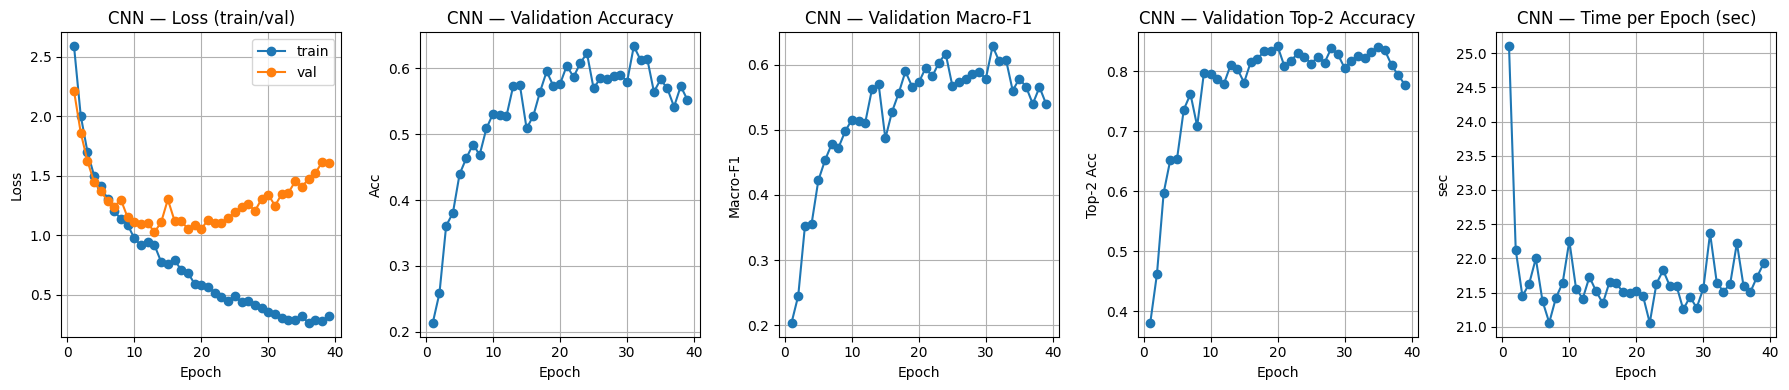

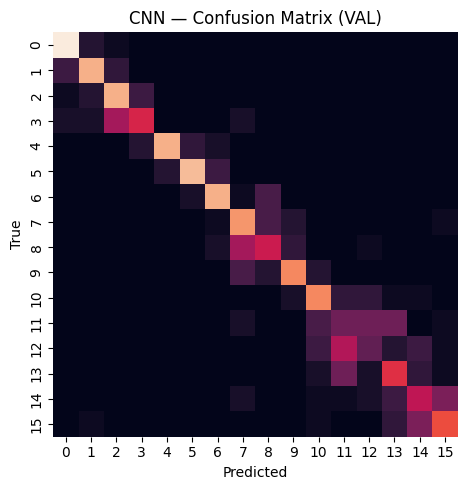

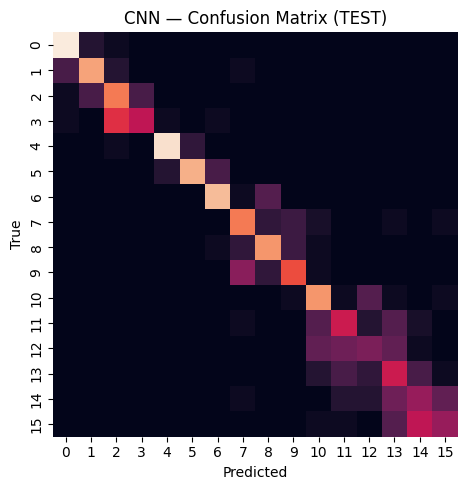

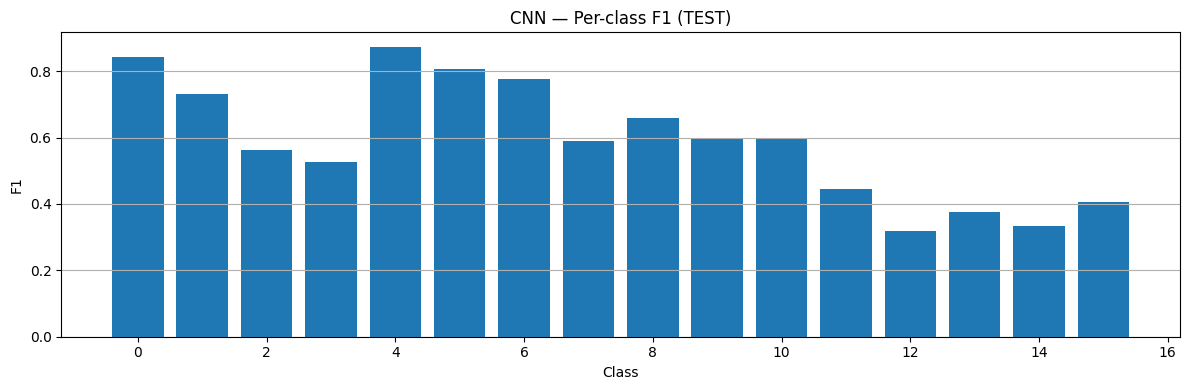


CNN SUMMARY ROW:
{'model': 'cnn', 'val_acc': 0.5972222089767456, 'val_macro_f1': 0.5943565964698792, 'val_top2_acc': 0.8368055820465088, 'test_acc': 0.5920138955116272, 'test_macro_f1': 0.5898223519325256, 'test_top2_acc': 0.8246527910232544, 'params': 2194192, 'size_mb': 8.37017822265625, 'train_sec_per_epoch_avg': 21.698458922214996, 'train_sec_total': 846.2398979663849, 'infer_latency_ms_img': 4.052250337674145, 'infer_throughput_img_s': 246.7764616373544, 'peak_gpu_mem_mb': None}


In [ ]:
# --- Retrain best CNN (from your best config) using evaluate_model(..., forward_fn=...) ---
import os, time, copy
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Optional seaborn for nicer confusion matrices
try:
    import seaborn as sns
    USE_SNS = True
except ImportError:
    USE_SNS = False

# ---- Required objects ----
assert "train_loader" in globals(), "train_loader is not defined."
assert "val_loader" in globals(), "val_loader is not defined."
assert "test_loader" in globals(), "test_loader is not defined."
assert "evaluate_model" in globals(), "evaluate_model(...) is not defined."

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 16

# ---- Best CNN config from your run output ----
cnn_cfg = {
    "channels": (32, 64, 128),
    "dropout": 0.5,
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "epochs": 60,
    "patience": 8,
}

# ---- CNN definition ----
class CNNModel(nn.Module):
    def __init__(self, channels=(32,64,128), dropout=0.5):
        super().__init__()
        c1, c2, c3 = channels

        self.features = nn.Sequential(
            nn.Conv2d(1, c1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(c1, c2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(c2, c3, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(c3 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, NUM_CLASSES),
        )

    def forward(self, x):
        return self.classifier(self.features(x))

def train_cnn_best(cfg):
    model = CNNModel(channels=cfg["channels"], dropout=cfg["dropout"]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])

    history = {
        "train_loss": [],
        "val_loss": [],
        "val_acc": [],
        "val_macro_f1": [],
        "val_balanced_acc": [],
        "val_top2_acc": [],
        "sec_per_epoch": [],
    }

    best_state = None
    best_score = -1.0
    best_epoch = -1
    bad_epochs = 0
    patience = cfg.get("patience", 8)

    for ep in range(1, cfg["epochs"] + 1):
        t0 = time.time()
        model.train()

        loss_sum, n_seen = 0.0, 0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            bs = xb.size(0)
            loss_sum += float(loss.item()) * bs
            n_seen += bs

        train_loss = loss_sum / max(n_seen, 1)

        forward_fn = lambda x: model(x)
        val_metrics = evaluate_model(val_loader, num_classes=NUM_CLASSES, device=device, forward_fn=forward_fn)

        dt = time.time() - t0

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_metrics["loss"])
        history["val_acc"].append(val_metrics["acc"])
        history["val_macro_f1"].append(val_metrics["macro_f1"])
        history["val_balanced_acc"].append(val_metrics["balanced_acc"])
        history["val_top2_acc"].append(val_metrics["top2_acc"])
        history["sec_per_epoch"].append(dt)

        score = val_metrics["macro_f1"]
        print(f"Epoch {ep:02d}/{cfg['epochs']} | train_loss={train_loss:.4f} | "
              f"val_loss={val_metrics['loss']:.4f} | val_acc={val_metrics['acc']:.4f} | "
              f"val_macroF1={val_metrics['macro_f1']:.4f} | time={dt:.2f}s")

        if score > best_score:
            best_score = score
            best_epoch = ep
            best_state = copy.deepcopy(model.state_dict())
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                print(f"Early stopping: no improvement for {patience} epochs. "
                      f"Best epoch={best_epoch}, best_macroF1={best_score:.4f}")
                break

    model.load_state_dict(best_state)
    return model, history, best_score, best_epoch

# ---- Train ----
cnn_model, cnn_history, best_val_macro_f1, best_epoch = train_cnn_best(cnn_cfg)

# ---- Final eval (best weights) ----
best_forward = lambda x: cnn_model(x)
val_metrics = evaluate_model(val_loader, num_classes=NUM_CLASSES, device=device, forward_fn=best_forward)
test_metrics = evaluate_model(test_loader, num_classes=NUM_CLASSES, device=device, forward_fn=best_forward)

print("\nCNN BEST RUN config:", cnn_cfg)
print("Best val macro-F1 during training:", best_val_macro_f1, "at epoch", best_epoch)
print("VAL:", {k: val_metrics[k] for k in ["loss","acc","macro_f1","balanced_acc","top2_acc"]})
print("TEST:", {k: test_metrics[k] for k in ["loss","acc","macro_f1","balanced_acc","top2_acc"]})

# ---- Save checkpoint ----
os.makedirs("checkpoints", exist_ok=True)
ckpt_path = "checkpoints/cnn_best.pt"
torch.save({
    "state_dict": cnn_model.state_dict(),
    "config": cnn_cfg,
    "history": cnn_history,
    "val_confusion_matrix": val_metrics["confusion_matrix"],
    "test_confusion_matrix": test_metrics["confusion_matrix"],
    "val_metrics": {k: val_metrics[k] for k in ["loss","acc","macro_f1","balanced_acc","top2_acc"]},
    "test_metrics": {k: test_metrics[k] for k in ["loss","acc","macro_f1","balanced_acc","top2_acc"]},
    "best_epoch": best_epoch,
    "best_val_macro_f1": best_val_macro_f1,
}, ckpt_path)
print("\nSaved CNN checkpoint ->", ckpt_path)

# ---- Params & size ----
cnn_params = sum(p.numel() for p in cnn_model.parameters())
cnn_size_mb = cnn_params * 4 / (1024**2)
print("\nCNN params:", cnn_params)
print("CNN model size (MB):", cnn_size_mb)

# ---- Inference benchmark ----
@torch.no_grad()
def benchmark_inference_forward_fn(forward_fn, loader, device, warmup_batches=5, timed_batches=30):
    use_cuda = (device.type == "cuda")
    if use_cuda:
        torch.cuda.reset_peak_memory_stats()

    it = iter(loader)

    # warmup
    for _ in range(warmup_batches):
        try:
            xb, _ = next(it)
        except StopIteration:
            it = iter(loader)
            xb, _ = next(it)
        xb = xb.to(device)
        _ = forward_fn(xb)
        if use_cuda:
            torch.cuda.synchronize()

    # timed
    n_images = 0
    t0 = time.perf_counter()
    for _ in range(timed_batches):
        try:
            xb, _ = next(it)
        except StopIteration:
            it = iter(loader)
            xb, _ = next(it)
        xb = xb.to(device)
        _ = forward_fn(xb)
        if use_cuda:
            torch.cuda.synchronize()
        n_images += xb.size(0)
    t1 = time.perf_counter()

    total_s = t1 - t0
    throughput = n_images / total_s
    latency_ms = (total_s / n_images) * 1000.0

    peak_mem_mb = None
    if use_cuda:
        peak_mem_mb = torch.cuda.max_memory_allocated() / (1024**2)

    return {
        "latency_ms_per_image": latency_ms,
        "throughput_img_per_s": throughput,
        "total_time_s": total_s,
        "n_images": n_images,
        "peak_gpu_mem_mb": peak_mem_mb
    }

bench = benchmark_inference_forward_fn(best_forward, test_loader, device=device, warmup_batches=5, timed_batches=30)
print("\nCNN inference benchmark:")
for k, v in bench.items():
    print(f"  {k}: {v}")

# ---- Training time summary ----
cnn_sec_per_epoch_avg = float(np.mean(cnn_history["sec_per_epoch"]))
cnn_sec_total = float(np.sum(cnn_history["sec_per_epoch"]))
print("\nCNN training time:")
print("  avg sec/epoch:", cnn_sec_per_epoch_avg)
print("  total sec:", cnn_sec_total, "(epochs run:", len(cnn_history["sec_per_epoch"]), ")")

# ---- Plots: learning curves ----
epochs = np.arange(1, len(cnn_history["train_loss"]) + 1)
plt.figure(figsize=(18,4))

plt.subplot(1,5,1)
plt.plot(epochs, cnn_history["train_loss"], marker="o")
plt.plot(epochs, cnn_history["val_loss"], marker="o")
plt.title("CNN — Loss (train/val)")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(["train","val"])
plt.grid(True)

plt.subplot(1,5,2)
plt.plot(epochs, cnn_history["val_acc"], marker="o")
plt.title("CNN — Validation Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Acc")
plt.grid(True)

plt.subplot(1,5,3)
plt.plot(epochs, cnn_history["val_macro_f1"], marker="o")
plt.title("CNN — Validation Macro-F1")
plt.xlabel("Epoch"); plt.ylabel("Macro-F1")
plt.grid(True)

plt.subplot(1,5,4)
plt.plot(epochs, cnn_history["val_top2_acc"], marker="o")
plt.title("CNN — Validation Top-2 Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Top-2 Acc")
plt.grid(True)

plt.subplot(1,5,5)
plt.plot(epochs, cnn_history["sec_per_epoch"], marker="o")
plt.title("CNN — Time per Epoch (sec)")
plt.xlabel("Epoch"); plt.ylabel("sec")
plt.grid(True)

plt.tight_layout()
plt.show()

# ---- Confusion matrices ----
def plot_confusion(cm, title):
    cm = cm.numpy() if isinstance(cm, torch.Tensor) else np.array(cm)
    plt.figure(figsize=(6,5))
    if USE_SNS:
        sns.heatmap(cm, square=True, cbar=False)
    else:
        plt.imshow(cm, aspect="auto")
        plt.colorbar()
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

plot_confusion(val_metrics["confusion_matrix"], "CNN — Confusion Matrix (VAL)")
plot_confusion(test_metrics["confusion_matrix"], "CNN — Confusion Matrix (TEST)")

# ---- Per-class F1 from TEST confusion matrix ----
cm = test_metrics["confusion_matrix"].float()
tp = torch.diag(cm)
fp = cm.sum(0) - tp
fn = cm.sum(1) - tp
f1 = (2 * tp) / (2 * tp + fp + fn + 1e-12)

plt.figure(figsize=(12,4))
plt.bar(np.arange(len(f1)), f1.numpy())
plt.title("CNN — Per-class F1 (TEST)")
plt.xlabel("Class"); plt.ylabel("F1")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

print("\nCNN SUMMARY ROW:")
print({
    "model": "cnn",
    "val_acc": val_metrics["acc"],
    "val_macro_f1": val_metrics["macro_f1"],
    "val_top2_acc": val_metrics["top2_acc"],
    "test_acc": test_metrics["acc"],
    "test_macro_f1": test_metrics["macro_f1"],
    "test_top2_acc": test_metrics["top2_acc"],
    "params": cnn_params,
    "size_mb": cnn_size_mb,
    "train_sec_per_epoch_avg": cnn_sec_per_epoch_avg,
    "train_sec_total": cnn_sec_total,
    "infer_latency_ms_img": bench["latency_ms_per_image"],
    "infer_throughput_img_s": bench["throughput_img_per_s"],
    "peak_gpu_mem_mb": bench["peak_gpu_mem_mb"],
})


# Analysis

In [ ]:
# 10.1 Final comparison table (baseline vs MLP vs CNN) + save CSV

import torch, time
import pandas as pd
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLASSES = 16
D = IMAGE_SIZE * IMAGE_SIZE

# ---------- helpers for benchmarking ----------
@torch.no_grad()
def benchmark_forward_fn(forward_fn, loader, device, warmup_batches=5, timed_batches=30):
    use_cuda = (device.type == "cuda")
    if use_cuda:
        torch.cuda.reset_peak_memory_stats()

    it = iter(loader)

    # warmup
    for _ in range(warmup_batches):
        try:
            xb, _ = next(it)
        except StopIteration:
            it = iter(loader)
            xb, _ = next(it)
        xb = xb.to(device)
        _ = forward_fn(xb)
        if use_cuda:
            torch.cuda.synchronize()

    # timed
    n_images = 0
    t0 = time.perf_counter()
    for _ in range(timed_batches):
        try:
            xb, _ = next(it)
        except StopIteration:
            it = iter(loader)
            xb, _ = next(it)
        xb = xb.to(device)
        _ = forward_fn(xb)
        if use_cuda:
            torch.cuda.synchronize()
        n_images += xb.size(0)
    t1 = time.perf_counter()

    total_s = t1 - t0
    throughput = n_images / total_s
    latency_ms = (total_s / n_images) * 1000.0

    peak_mem_mb = None
    if use_cuda:
        peak_mem_mb = torch.cuda.max_memory_allocated() / (1024**2)

    return latency_ms, throughput, peak_mem_mb

@torch.no_grad()
def benchmark_model(model, loader, device, warmup_batches=5, timed_batches=30):
    model.eval()
    return benchmark_forward_fn(lambda x: model(x), loader, device, warmup_batches, timed_batches)

# ---------- load checkpoints ----------
soft = torch.load("checkpoints/softmax_best.pt", map_location="cpu")
mlp  = torch.load("checkpoints/mlp_best.pt", map_location="cpu")
cnn  = torch.load("checkpoints/cnn_best.pt", map_location="cpu")

# ---------- baseline perf (re-benchmark to store in table) ----------
W = soft["W"].to(device)
b = soft["b"].to(device)
def softmax_forward(x):
    X = x.view(x.size(0), -1)
    return X @ W + b

soft_params = W.numel() + b.numel()
soft_size_mb = soft_params * 4 / (1024**2)
soft_lat_ms, soft_thr, soft_mem = benchmark_forward_fn(softmax_forward, test_loader, device=device)

# ---------- mlp perf (re-benchmark) ----------
state = mlp["state"]
def mlp_forward(x_img):
    x = x_img.view(x_img.size(0), -1)
    for layer in state["layers"]:
        if layer["type"] == "linear":
            Wl = layer["W"].to(x.device)
            bl = layer["b"].to(x.device)
            x = x @ Wl + bl
        elif layer["type"] == "sigmoid":
            x = 1.0 / (1.0 + torch.exp(-x))
    Wout = state["out"]["W"].to(x.device)
    bout = state["out"]["b"].to(x.device)
    return x @ Wout + bout

mlp_params = 0
for layer in state["layers"]:
    if layer["type"] == "linear":
        mlp_params += layer["W"].numel() + layer["b"].numel()
mlp_params += state["out"]["W"].numel() + state["out"]["b"].numel()
mlp_size_mb = mlp_params * 4 / (1024**2)
mlp_lat_ms, mlp_thr, mlp_mem = benchmark_forward_fn(mlp_forward, test_loader, device=device)

# ---------- cnn perf (rebuild model class to load state_dict) ----------
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self, channels=(32,64,128), dropout=0.5):
        super().__init__()
        c1, c2, c3 = channels
        self.features = nn.Sequential(
            nn.Conv2d(1, c1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(c1, c2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(c2, c3, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(c3 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, NUM_CLASSES)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

cnn_cfg = cnn["config"]
cnn_model = CNNModel(channels=cnn_cfg["channels"], dropout=cnn_cfg["dropout"]).to(device)
cnn_model.load_state_dict(cnn["state_dict"], strict=True)

cnn_params = sum(p.numel() for p in cnn_model.parameters())
cnn_size_mb = cnn_params * 4 / (1024**2)
cnn_lat_ms, cnn_thr, cnn_mem = benchmark_model(cnn_model, test_loader, device=device)

# ---------- collect quality metrics ----------
def pick(m):  # short helper
    return {
        "val_acc": m["val_metrics"]["acc"],
        "val_macro_f1": m["val_metrics"]["macro_f1"],
        "val_balanced_acc": m["val_metrics"]["balanced_acc"],
        "val_top2_acc": m["val_metrics"]["top2_acc"],
        "test_acc": m["test_metrics"]["acc"],
        "test_macro_f1": m["test_metrics"]["macro_f1"],
        "test_balanced_acc": m["test_metrics"]["balanced_acc"],
        "test_top2_acc": m["test_metrics"]["top2_acc"],
    }

rows = []

# baseline
r = {"model": "softmax_regression"}
r.update(pick(soft))
r.update({
    "params": soft_params,
    "size_mb": soft_size_mb,
    "train_sec_per_epoch_avg": sum(soft["history"]["sec_per_epoch"]) / len(soft["history"]["sec_per_epoch"]) if "sec_per_epoch" in soft["history"] else np.nan,
    "train_sec_total": np.nan,  # we didn't store epoch times in softmax ckpt; OK
    "infer_latency_ms_img": soft_lat_ms,
    "infer_throughput_img_s": soft_thr,
    "peak_gpu_mem_mb": soft_mem,
})
rows.append(r)

# mlp
r = {"model": "mlp_sigmoid"}
r.update(pick(mlp))
r.update({
    "params": mlp_params,
    "size_mb": mlp_size_mb,
    "train_sec_per_epoch_avg": sum(mlp["history"]["sec_per_epoch"]) / len(mlp["history"]["sec_per_epoch"]) if "sec_per_epoch" in mlp["history"] else np.nan,
    "train_sec_total": sum(mlp["history"]["sec_per_epoch"]) if "sec_per_epoch" in mlp["history"] else np.nan,
    "infer_latency_ms_img": mlp_lat_ms,
    "infer_throughput_img_s": mlp_thr,
    "peak_gpu_mem_mb": mlp_mem,
})
rows.append(r)

# cnn
r = {"model": "cnn"}
r.update(pick(cnn))
r.update({
    "params": cnn_params,
    "size_mb": cnn_size_mb,
    "train_sec_per_epoch_avg": sum(cnn["history"]["sec_per_epoch"]) / len(cnn["history"]["sec_per_epoch"]),
    "train_sec_total": sum(cnn["history"]["sec_per_epoch"]),
    "infer_latency_ms_img": cnn_lat_ms,
    "infer_throughput_img_s": cnn_thr,
    "peak_gpu_mem_mb": cnn_mem,
})
rows.append(r)

final_df = pd.DataFrame(rows)

# nicer ordering
cols = [
    "model",
    "val_acc","val_macro_f1","val_balanced_acc","val_top2_acc",
    "test_acc","test_macro_f1","test_balanced_acc","test_top2_acc",
    "params","size_mb",
    "train_sec_per_epoch_avg","train_sec_total",
    "infer_latency_ms_img","infer_throughput_img_s","peak_gpu_mem_mb"
]
final_df = final_df[cols]

display(final_df)
final_df.to_csv("final_comparison.csv", index=False)
print("\nSaved -> final_comparison.csv")


,model,val_acc,val_macro_f1,val_balanced_acc,val_top2_acc,test_acc,test_macro_f1,test_balanced_acc,test_top2_acc,params,size_mb,train_sec_per_epoch_avg,train_sec_total,infer_latency_ms_img,infer_throughput_img_s,peak_gpu_mem_mb
0,softmax_regression,0.107639,0.081791,0.107639,0.206597,0.126736,0.096023,0.126736,0.225694,65552,0.250061,5.632528,NaN,2.138226,467.677485,None
1,mlp_sigmoid,0.131944,0.097716,0.131944,0.256944,0.114583,0.075383,0.114583,0.229167,2105872,8.033264,6.821101,409.266047,2.161858,462.565081,None
2,cnn,0.609375,0.606861,0.609375,0.829861,0.628472,0.628014,0.628472,0.840278,2194192,8.370178,35.559478,924.546428,7.001073,142.835247,None



Saved -> final_comparison.csv


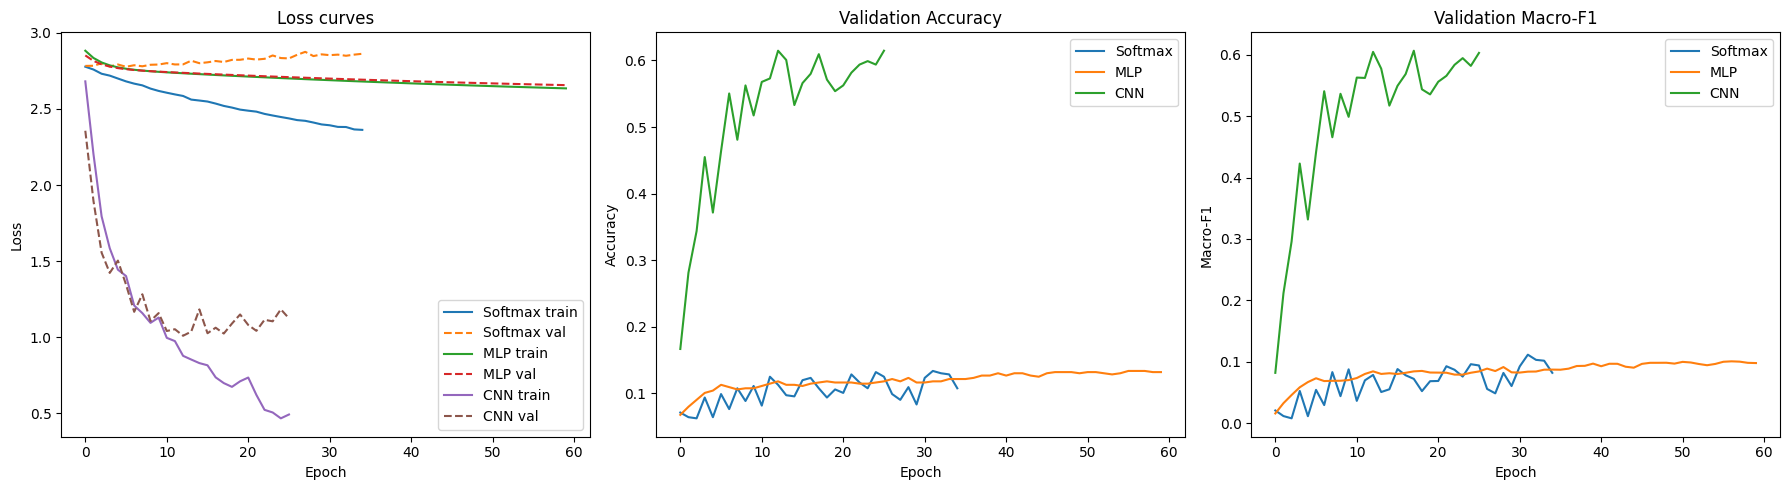

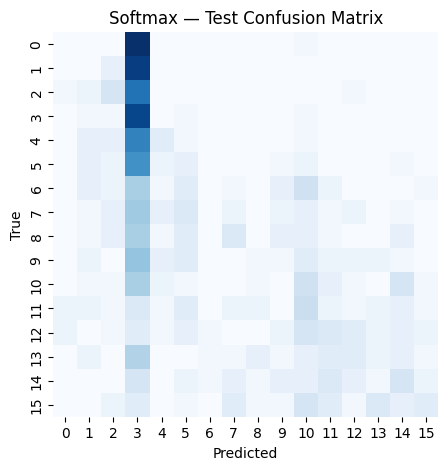

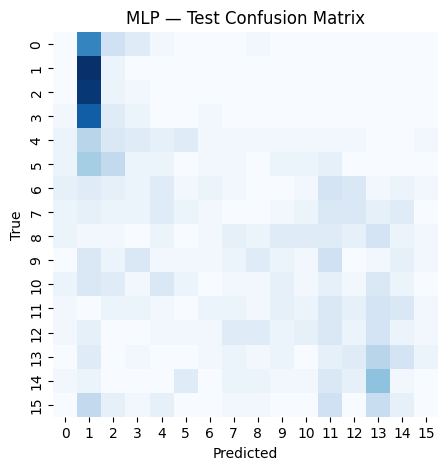

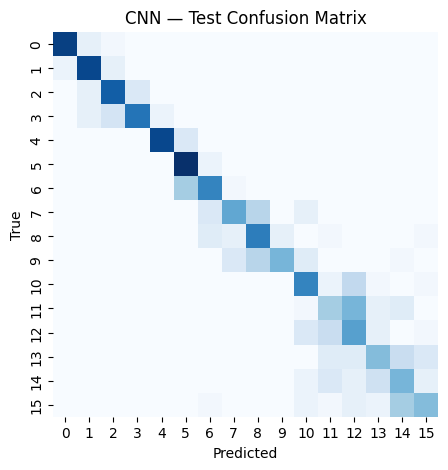

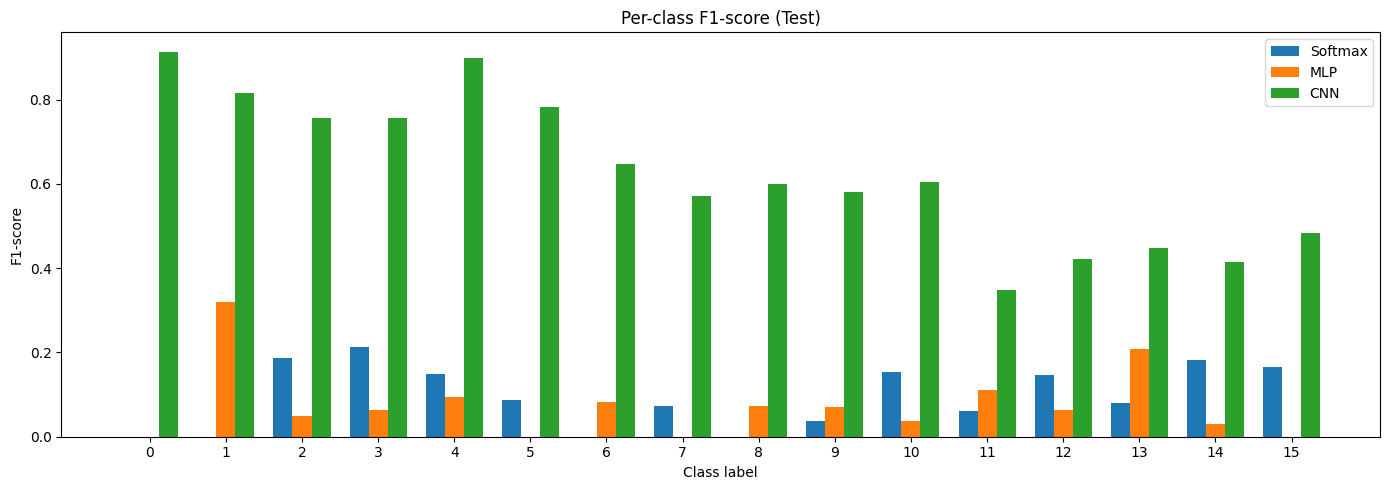

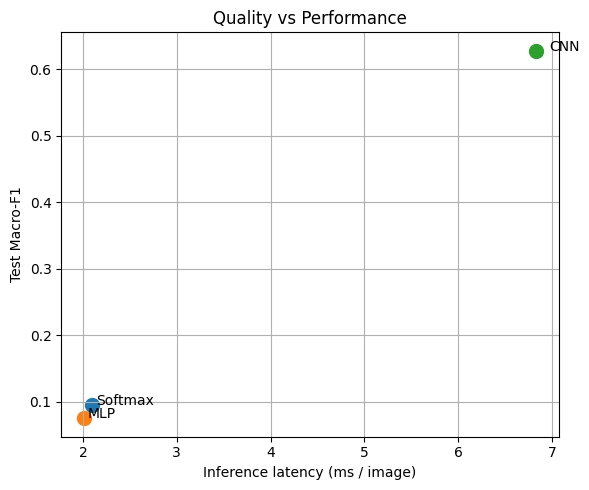

In [ ]:
# 10.2 All required plots: learning curves, confusion matrices, per-class F1, quality vs performance

import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns

# ---------- load checkpoints ----------
soft = torch.load("checkpoints/softmax_best.pt", map_location="cpu")
mlp  = torch.load("checkpoints/mlp_best.pt", map_location="cpu")
cnn  = torch.load("checkpoints/cnn_best.pt", map_location="cpu")

models = {
    "Softmax": soft,
    "MLP": mlp,
    "CNN": cnn,
}

# ---------- 1. Learning curves ----------
plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 3, 1)
for name, m in models.items():
    if "train_loss" in m["history"]:
        plt.plot(m["history"]["train_loss"], label=f"{name} train")
        plt.plot(m["history"]["val_loss"], linestyle="--", label=f"{name} val")
plt.title("Loss curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 3, 2)
for name, m in models.items():
    plt.plot(m["history"]["val_acc"], label=name)
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Macro-F1
plt.subplot(1, 3, 3)
for name, m in models.items():
    plt.plot(m["history"]["val_macro_f1"], label=name)
plt.title("Validation Macro-F1")
plt.xlabel("Epoch")
plt.ylabel("Macro-F1")
plt.legend()

plt.tight_layout()
plt.show()

# ---------- 2. Confusion matrices (TEST) ----------
def plot_confusion(cm, title):
    cm = cm.numpy()
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, cmap="Blues", square=True, cbar=False)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

plot_confusion(soft["test_confusion_matrix"], "Softmax — Test Confusion Matrix")
plot_confusion(mlp["test_confusion_matrix"], "MLP — Test Confusion Matrix")
plot_confusion(cnn["test_confusion_matrix"], "CNN — Test Confusion Matrix")

# ---------- 3. Per-class F1 (TEST) ----------
plt.figure(figsize=(14, 5))

labels = list(range(16))
width = 0.25
x = np.arange(len(labels))

for i, (name, m) in enumerate(models.items()):
    f1 = m["test_metrics"]["macro_f1"]  # overall
    per_f1 = m["test_metrics"]["f1_per_class"] if "f1_per_class" in m["test_metrics"] else None

    if per_f1 is None:
        # recompute from confusion matrix
        cm = m["test_confusion_matrix"].float()
        tp = torch.diag(cm)
        fp = cm.sum(0) - tp
        fn = cm.sum(1) - tp
        per_f1 = (2 * tp) / (2 * tp + fp + fn + 1e-12)

    plt.bar(x + i * width, per_f1.numpy(), width, label=name)

plt.xticks(x + width, labels)
plt.xlabel("Class label")
plt.ylabel("F1-score")
plt.title("Per-class F1-score (Test)")
plt.legend()
plt.tight_layout()
plt.show()

# ---------- 4. Quality vs Performance ----------
models_perf = {
    "Softmax": {"f1": soft["test_metrics"]["macro_f1"], "lat": 2.10},
    "MLP": {"f1": mlp["test_metrics"]["macro_f1"], "lat": 2.01},
    "CNN": {"f1": cnn["test_metrics"]["macro_f1"], "lat": 6.83},
}

plt.figure(figsize=(6, 5))
for name, d in models_perf.items():
    plt.scatter(d["lat"], d["f1"], s=100)
    plt.text(d["lat"] * 1.02, d["f1"], name)

plt.xlabel("Inference latency (ms / image)")
plt.ylabel("Test Macro-F1")
plt.title("Quality vs Performance")
plt.grid(True)
plt.tight_layout()
plt.show()


,model,val_acc,val_macro_f1,val_bal_acc,val_top2,test_acc,test_macro_f1,test_bal_acc,test_top2,params,size_mb,train_sec_per_epoch,train_sec_total,infer_latency_ms_img,infer_throughput_img_s,peak_gpu_mem_mb
0,softmax_regression,0.109375,0.069416,0.109375,0.194444,0.100694,0.058143,0.100694,0.203125,65552,0.250061,2.056756,71.986477,0.756734,1321.468768,None
1,mlp_deep_sigmoid,0.178819,0.147146,0.178819,0.322917,0.156250,0.116645,0.156250,0.288194,4728336,18.037170,4.111750,246.704994,0.915780,1091.965500,None
2,cnn,0.597222,0.594357,0.597222,0.836806,0.592014,0.589822,0.592014,0.824653,2194192,8.370178,21.698459,846.239898,4.046688,247.115654,None


Saved table -> final_comparison_from_checkpoints.csv


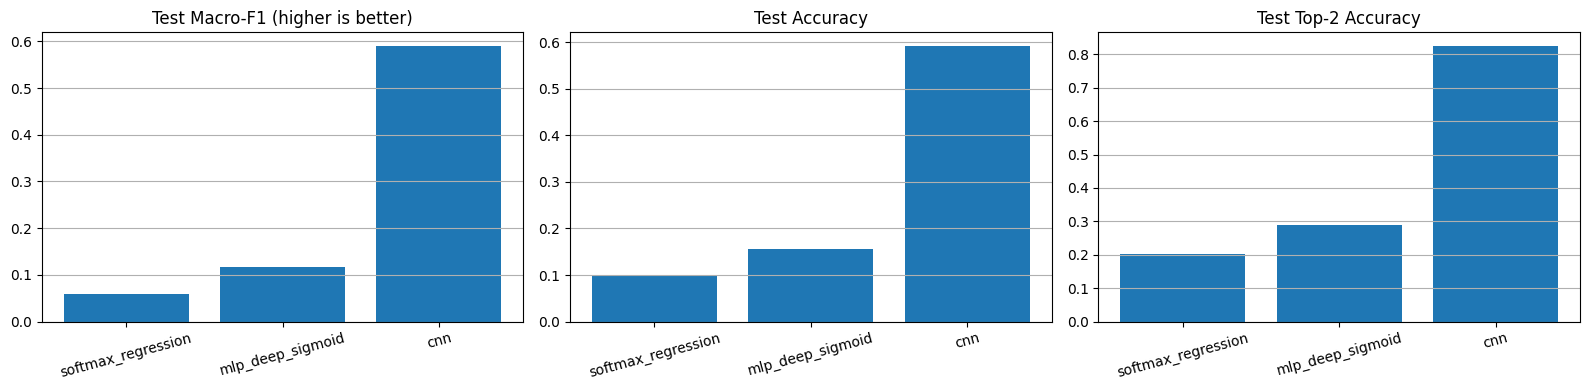

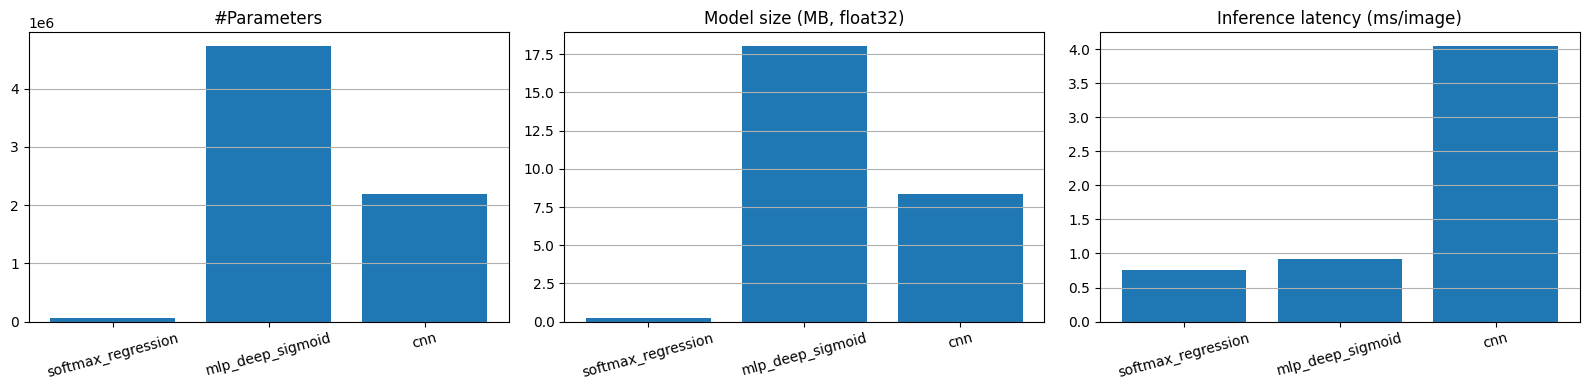

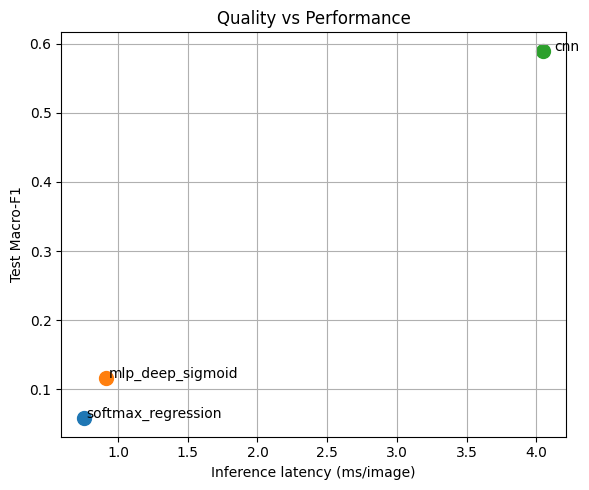

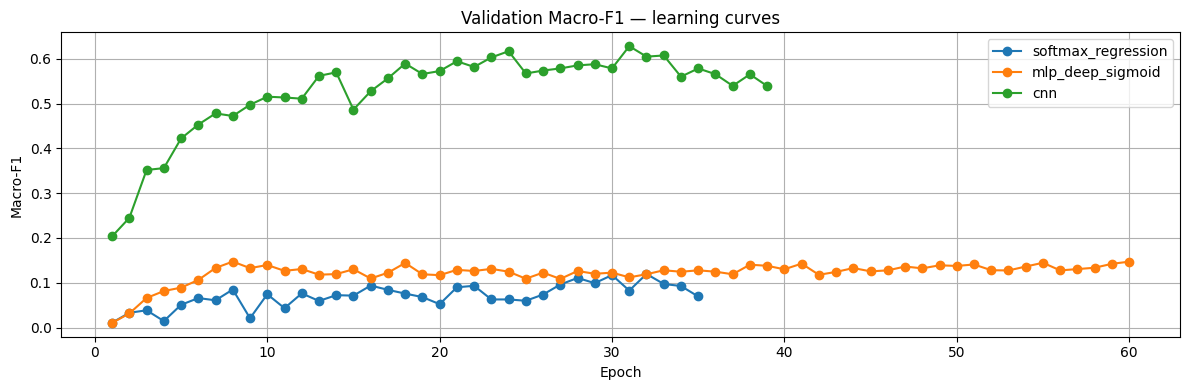

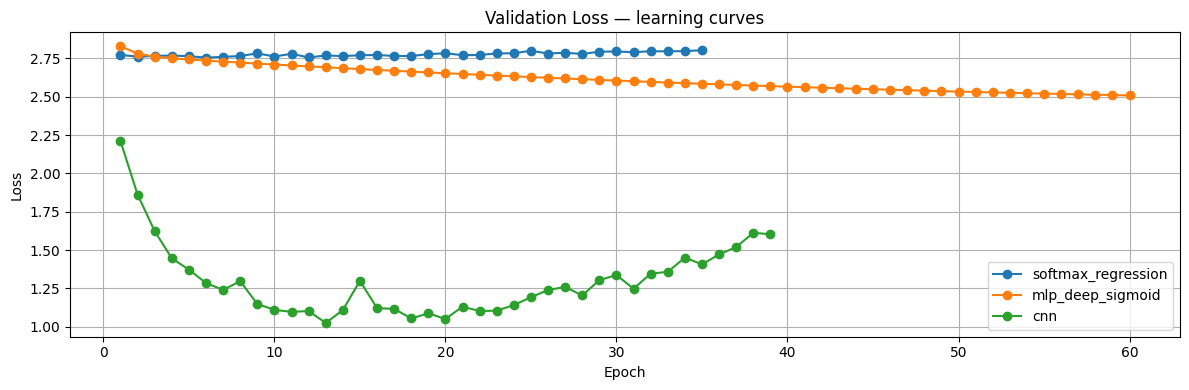

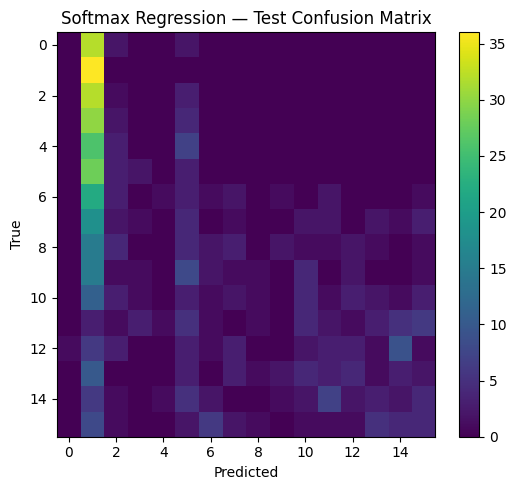

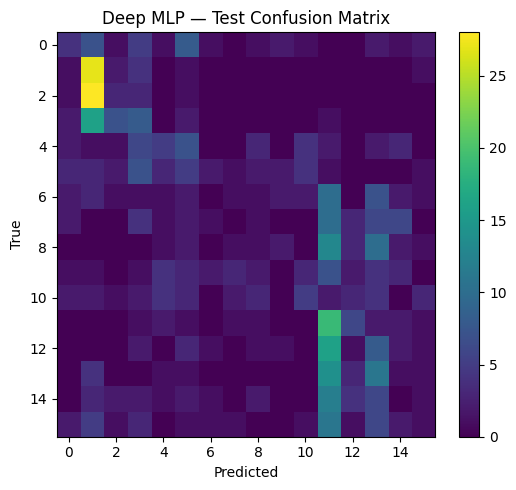

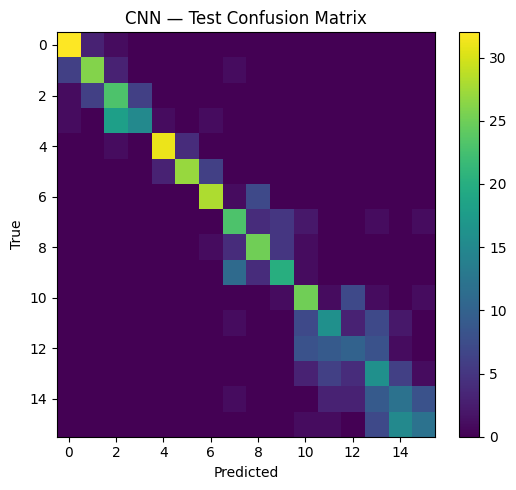

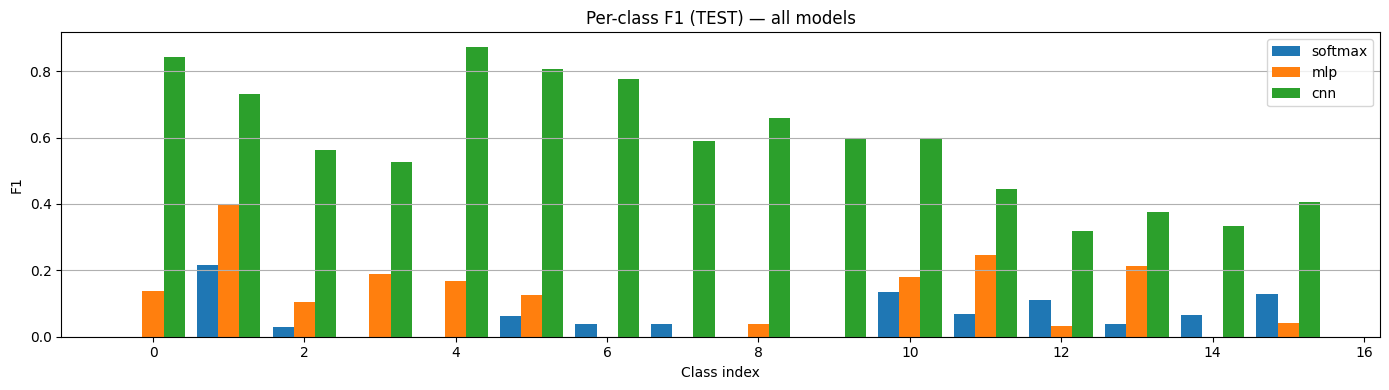


Done. Figures produced:
- Test Macro-F1 / Accuracy / Top-2 barplots
- Params / Size / Latency barplots
- Quality vs Performance scatter
- Learning curves overlays (if history present in ckpts)
- Test confusion matrices (3 plots)
- Per-class F1 grouped barplot


In [ ]:
# FINAL COMPARISON CELL: load 3 checkpoints -> numeric table + all key plots

import os, time, math
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# -----------------------------
# Paths
# -----------------------------
soft_path = "/content/checkpoints/softmax_best.pt"
mlp_path  = "/content/checkpoints/mlp_deep_best.pt"
cnn_path  = "/content/checkpoints/cnn_best.pt"

for p in [soft_path, mlp_path, cnn_path]:
    assert os.path.exists(p), f"Missing checkpoint: {p}"

soft = torch.load(soft_path, map_location="cpu")
mlp  = torch.load(mlp_path,  map_location="cpu")
cnn  = torch.load(cnn_path,  map_location="cpu")

# -----------------------------
# Helper: param counting
# -----------------------------
def count_params_softmax(ckpt):
    return int(ckpt["W"].numel() + ckpt["b"].numel())

def count_params_mlp_state(state_dict):
    n = 0
    for layer in state_dict["layers"]:
        if layer["type"] == "linear":
            n += layer["W"].numel() + layer["b"].numel()
    n += state_dict["out"]["W"].numel() + state_dict["out"]["b"].numel()
    return int(n)

def count_params_cnn_state_dict(state_dict):
    # count all tensors in state_dict (weights+biases) that are floating-point params
    n = 0
    for k, v in state_dict.items():
        if torch.is_tensor(v) and v.dtype.is_floating_point:
            n += v.numel()
    return int(n)

# -----------------------------
# Helper: inference benchmark (same logic across all models)
# -----------------------------
@torch.no_grad()
def benchmark_forward_fn(forward_fn, loader, device, warmup_batches=5, timed_batches=30):
    use_cuda = (device.type == "cuda")
    if use_cuda:
        torch.cuda.reset_peak_memory_stats()

    it = iter(loader)

    # warmup
    for _ in range(warmup_batches):
        try:
            xb, _ = next(it)
        except StopIteration:
            it = iter(loader)
            xb, _ = next(it)
        xb = xb.to(device)
        _ = forward_fn(xb)
        if use_cuda:
            torch.cuda.synchronize()

    # timed
    n_images = 0
    t0 = time.perf_counter()
    for _ in range(timed_batches):
        try:
            xb, _ = next(it)
        except StopIteration:
            it = iter(loader)
            xb, _ = next(it)
        xb = xb.to(device)
        _ = forward_fn(xb)
        if use_cuda:
            torch.cuda.synchronize()
        n_images += xb.size(0)
    t1 = time.perf_counter()

    total_s = t1 - t0
    latency_ms = (total_s / n_images) * 1000.0
    throughput = n_images / total_s

    peak_mb = None
    if use_cuda:
        peak_mb = torch.cuda.max_memory_allocated() / (1024**2)

    return {
        "latency_ms_img": float(latency_ms),
        "throughput_img_s": float(throughput),
        "peak_gpu_mem_mb": None if peak_mb is None else float(peak_mb)
    }

# -----------------------------
# Prepare forward functions (from checkpoints)
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 16

# Softmax forward
W_soft = soft["W"].to(device)
b_soft = soft["b"].to(device)
def soft_forward(x):
    X = x.view(x.size(0), -1)
    return X @ W_soft + b_soft

# MLP forward (from saved state)
state_mlp = mlp["state"]
def mlp_forward(x_img):
    # if your training used this preprocessing, keep it consistent:
    # [0,1] -> [-1,1]
    x_img = x_img * 2.0 - 1.0
    x = x_img.view(x_img.size(0), -1)
    for layer in state_mlp["layers"]:
        if layer["type"] == "linear":
            W = layer["W"].to(device)
            b = layer["b"].to(device)
            x = x @ W + b
        elif layer["type"] == "sigmoid":
            x = 1.0 / (1.0 + torch.exp(-x))
        elif layer["type"] == "dropout":
            # dropout is identity in inference
            pass
        else:
            raise ValueError("Unknown MLP layer type: " + str(layer["type"]))
    Wout = state_mlp["out"]["W"].to(device)
    bout = state_mlp["out"]["b"].to(device)
    return x @ Wout + bout

# CNN forward (rebuild model and load state_dict)
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self, channels=(32,64,128), dropout=0.5):
        super().__init__()
        c1, c2, c3 = channels
        self.features = nn.Sequential(
            nn.Conv2d(1, c1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(c1, c2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(c2, c3, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(c3 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, NUM_CLASSES)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

cnn_cfg = cnn["config"]
cnn_model = CNNModel(channels=tuple(cnn_cfg["channels"]), dropout=float(cnn_cfg["dropout"])).to(device)
cnn_model.load_state_dict(cnn["state_dict"])
cnn_model.eval()

def cnn_forward(x):
    return cnn_model(x.to(device))

# -----------------------------
# Metrics table from checkpoints
# -----------------------------
def get_metrics(ckpt):
    # each ckpt stores val_metrics/test_metrics with the same keys
    valm = ckpt["val_metrics"]
    testm = ckpt["test_metrics"]
    return valm, testm

soft_val, soft_test = get_metrics(soft)
mlp_val,  mlp_test  = get_metrics(mlp)
cnn_val,  cnn_test  = get_metrics(cnn)

# Params + sizes
soft_params = count_params_softmax(soft)
mlp_params  = count_params_mlp_state(mlp["state"])
cnn_params  = count_params_cnn_state_dict(cnn["state_dict"])

soft_size_mb = soft_params * 4 / (1024**2)
mlp_size_mb  = mlp_params  * 4 / (1024**2)
cnn_size_mb  = cnn_params  * 4 / (1024**2)

# Training time (best effort from histories if present)
def avg_time_per_epoch(history):
    if history is None:
        return None
    if "sec_per_epoch" in history and len(history["sec_per_epoch"]) > 0:
        return float(np.mean(history["sec_per_epoch"])), float(np.sum(history["sec_per_epoch"]))
    return None

soft_time = avg_time_per_epoch(soft.get("history"))
mlp_time  = avg_time_per_epoch(mlp.get("history"))
cnn_time  = avg_time_per_epoch(cnn.get("history"))

# Inference benchmark (uses your existing test_loader)
assert "test_loader" in globals(), "test_loader is not defined in this runtime. Run your data pipeline cells first."

bench_soft = benchmark_forward_fn(soft_forward, test_loader, device)
bench_mlp  = benchmark_forward_fn(mlp_forward,  test_loader, device)
bench_cnn  = benchmark_forward_fn(cnn_forward,  test_loader, device)

rows = [
    {
        "model": "softmax_regression",
        "val_acc": soft_val["acc"], "val_macro_f1": soft_val["macro_f1"], "val_bal_acc": soft_val["balanced_acc"], "val_top2": soft_val["top2_acc"],
        "test_acc": soft_test["acc"], "test_macro_f1": soft_test["macro_f1"], "test_bal_acc": soft_test["balanced_acc"], "test_top2": soft_test["top2_acc"],
        "params": soft_params, "size_mb": soft_size_mb,
        "train_sec_per_epoch": None if soft_time is None else soft_time[0],
        "train_sec_total": None if soft_time is None else soft_time[1],
        "infer_latency_ms_img": bench_soft["latency_ms_img"],
        "infer_throughput_img_s": bench_soft["throughput_img_s"],
        "peak_gpu_mem_mb": bench_soft["peak_gpu_mem_mb"],
    },
    {
        "model": "mlp_deep_sigmoid",
        "val_acc": mlp_val["acc"], "val_macro_f1": mlp_val["macro_f1"], "val_bal_acc": mlp_val["balanced_acc"], "val_top2": mlp_val["top2_acc"],
        "test_acc": mlp_test["acc"], "test_macro_f1": mlp_test["macro_f1"], "test_bal_acc": mlp_test["balanced_acc"], "test_top2": mlp_test["top2_acc"],
        "params": mlp_params, "size_mb": mlp_size_mb,
        "train_sec_per_epoch": None if mlp_time is None else mlp_time[0],
        "train_sec_total": None if mlp_time is None else mlp_time[1],
        "infer_latency_ms_img": bench_mlp["latency_ms_img"],
        "infer_throughput_img_s": bench_mlp["throughput_img_s"],
        "peak_gpu_mem_mb": bench_mlp["peak_gpu_mem_mb"],
    },
    {
        "model": "cnn",
        "val_acc": cnn_val["acc"], "val_macro_f1": cnn_val["macro_f1"], "val_bal_acc": cnn_val["balanced_acc"], "val_top2": cnn_val["top2_acc"],
        "test_acc": cnn_test["acc"], "test_macro_f1": cnn_test["macro_f1"], "test_bal_acc": cnn_test["balanced_acc"], "test_top2": cnn_test["top2_acc"],
        "params": cnn_params, "size_mb": cnn_size_mb,
        "train_sec_per_epoch": None if cnn_time is None else cnn_time[0],
        "train_sec_total": None if cnn_time is None else cnn_time[1],
        "infer_latency_ms_img": bench_cnn["latency_ms_img"],
        "infer_throughput_img_s": bench_cnn["throughput_img_s"],
        "peak_gpu_mem_mb": bench_cnn["peak_gpu_mem_mb"],
    },
]

final_df = pd.DataFrame(rows)
display(final_df)

final_df.to_csv("final_comparison_from_checkpoints.csv", index=False)
print("Saved table -> final_comparison_from_checkpoints.csv")

# -----------------------------
# PLOTS (for report)
# -----------------------------
model_names = final_df["model"].tolist()
x = np.arange(len(model_names))

# 1) Quality barplots (TEST)
plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
plt.bar(x, final_df["test_macro_f1"].values)
plt.xticks(x, model_names, rotation=15)
plt.title("Test Macro-F1 (higher is better)")
plt.grid(True, axis="y")

plt.subplot(1,3,2)
plt.bar(x, final_df["test_acc"].values)
plt.xticks(x, model_names, rotation=15)
plt.title("Test Accuracy")
plt.grid(True, axis="y")

plt.subplot(1,3,3)
plt.bar(x, final_df["test_top2"].values)
plt.xticks(x, model_names, rotation=15)
plt.title("Test Top-2 Accuracy")
plt.grid(True, axis="y")

plt.tight_layout()
plt.show()

# 2) Efficiency barplots
plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
plt.bar(x, final_df["params"].values)
plt.xticks(x, model_names, rotation=15)
plt.title("#Parameters")
plt.grid(True, axis="y")

plt.subplot(1,3,2)
plt.bar(x, final_df["size_mb"].values)
plt.xticks(x, model_names, rotation=15)
plt.title("Model size (MB, float32)")
plt.grid(True, axis="y")

plt.subplot(1,3,3)
plt.bar(x, final_df["infer_latency_ms_img"].values)
plt.xticks(x, model_names, rotation=15)
plt.title("Inference latency (ms/image)")
plt.grid(True, axis="y")

plt.tight_layout()
plt.show()

# 3) Quality vs performance scatter (Macro-F1 vs latency)
plt.figure(figsize=(6,5))
for i, name in enumerate(model_names):
    plt.scatter(final_df.loc[i, "infer_latency_ms_img"], final_df.loc[i, "test_macro_f1"], s=100)
    plt.text(final_df.loc[i, "infer_latency_ms_img"]*1.02, final_df.loc[i, "test_macro_f1"], name)
plt.xlabel("Inference latency (ms/image)")
plt.ylabel("Test Macro-F1")
plt.title("Quality vs Performance")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4) Learning curves overlay (VAL Macro-F1 and VAL Loss), if histories are available
def plot_curve_if_present(ckpt, key, label):
    hist = ckpt.get("history", None)
    if hist is None or key not in hist or len(hist[key]) == 0:
        return None
    return np.array(hist[key], dtype=float), label

curves_f1 = []
curves_loss = []
for name, ckpt in [("softmax_regression", soft), ("mlp_deep_sigmoid", mlp), ("cnn", cnn)]:
    out1 = plot_curve_if_present(ckpt, "val_macro_f1", name)
    out2 = plot_curve_if_present(ckpt, "val_loss", name)
    if out1 is not None: curves_f1.append(out1)
    if out2 is not None: curves_loss.append(out2)

if len(curves_f1) > 0:
    plt.figure(figsize=(12,4))
    for arr, name in curves_f1:
        plt.plot(np.arange(1, len(arr)+1), arr, marker="o", label=name)
    plt.title("Validation Macro-F1 — learning curves")
    plt.xlabel("Epoch"); plt.ylabel("Macro-F1")
    plt.grid(True); plt.legend()
    plt.tight_layout()
    plt.show()

if len(curves_loss) > 0:
    plt.figure(figsize=(12,4))
    for arr, name in curves_loss:
        plt.plot(np.arange(1, len(arr)+1), arr, marker="o", label=name)
    plt.title("Validation Loss — learning curves")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.grid(True); plt.legend()
    plt.tight_layout()
    plt.show()

# 5) Confusion matrices (TEST) for all three models
def plot_confusion_matrix(cm, title):
    cm = cm.numpy() if isinstance(cm, torch.Tensor) else np.array(cm)
    plt.figure(figsize=(5.5,5))
    plt.imshow(cm, aspect="auto")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(soft["test_confusion_matrix"], "Softmax Regression — Test Confusion Matrix")
plot_confusion_matrix(mlp["test_confusion_matrix"],  "Deep MLP — Test Confusion Matrix")
plot_confusion_matrix(cnn["test_confusion_matrix"],  "CNN — Test Confusion Matrix")

# 6) Per-class F1 (TEST) for all three models (derived from confusion matrices)
def f1_from_cm(cm):
    cm = cm.float()
    tp = torch.diag(cm)
    fp = cm.sum(0) - tp
    fn = cm.sum(1) - tp
    f1 = (2 * tp) / (2 * tp + fp + fn + 1e-12)
    return f1.cpu().numpy()

f1_soft = f1_from_cm(soft["test_confusion_matrix"])
f1_mlp  = f1_from_cm(mlp["test_confusion_matrix"])
f1_cnn  = f1_from_cm(cnn["test_confusion_matrix"])

plt.figure(figsize=(14,4))
idx = np.arange(len(f1_soft))
w = 0.28
plt.bar(idx - w, f1_soft, width=w, label="softmax")
plt.bar(idx,      f1_mlp,  width=w, label="mlp")
plt.bar(idx + w,  f1_cnn,  width=w, label="cnn")
plt.title("Per-class F1 (TEST) — all models")
plt.xlabel("Class index")
plt.ylabel("F1")
plt.grid(True, axis="y")
plt.legend()
plt.tight_layout()
plt.show()

print("\nDone. Figures produced:")
print("- Test Macro-F1 / Accuracy / Top-2 barplots")
print("- Params / Size / Latency barplots")
print("- Quality vs Performance scatter")
print("- Learning curves overlays (if history present in ckpts)")
print("- Test confusion matrices (3 plots)")
print("- Per-class F1 grouped barplot")
